In [ ]:
"""
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

M2Bomber
dom.ria.com
realtor.ua
forbes.ua

Вартість в доларах із-за нестабільності курса валют 

Будівництво скоротилося, попит обвалився, але ціни не падають. Дослідження ринку нерухомості під час війни від Ernst & Young. 

Датасет для квартир

"""


In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [62]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Ціна в $/м²  \
0                             2                       1         1644   
1                             2                       1         1500   
2                             2                       2         1656   
3                             2                       2         1417   
4                             2                       1         1500   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  Вартість  \
0                             1                          4     96996   
1                             1       

/var/folders/fv/4htbnq6d04q4hfws4ch0x0fm0000gn/T/ipykernel_44274/3292880243.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


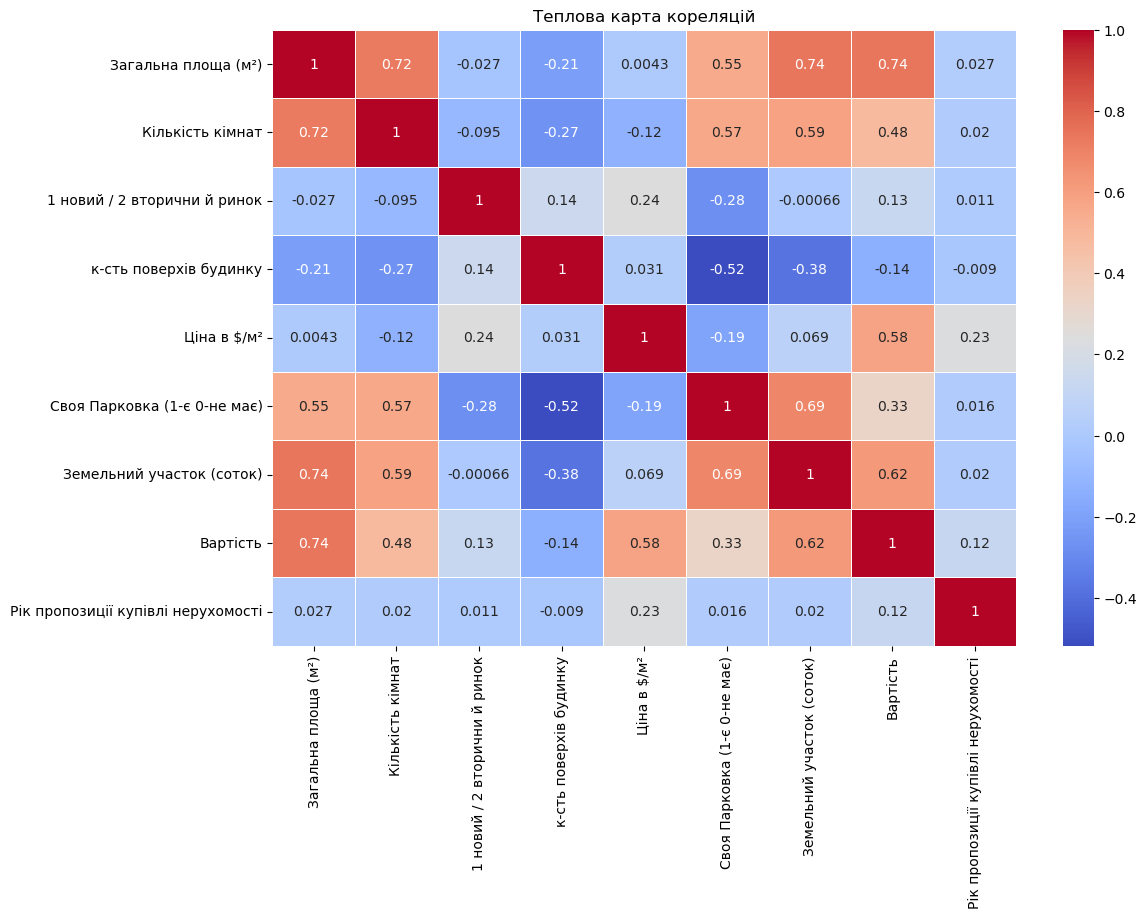

In [54]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()



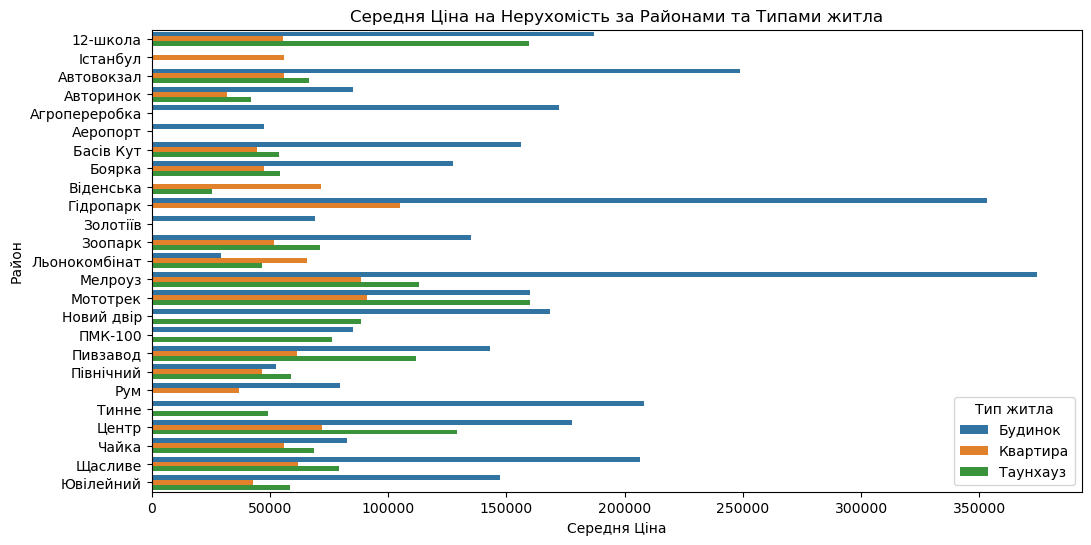

In [20]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [22]:
# Виведення загальної інформації про датасет
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Район                               2314 non-null   object
 1   Тип житла                           2314 non-null   object
 2   Загальна площа (м²)                 2314 non-null   int64 
 3   Кількість кімнат                    2314 non-null   int64 
 4   1 новий / 2 вторични й ринок        2314 non-null   int64 
 5   к-сть поверхів будинку              2314 non-null   int64 
 6   Ціна в $/м²                         2314 non-null   int64 
 7   Своя Парковка (1-є 0-не має)        2314 non-null   int64 
 8   Земельний участок (соток)           2314 non-null   int64 
 9   Вартість                            2314 non-null   int64 
 10  Рік пропозиції купівлі нерухомості  2314 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 199.0+ KB
None


In [24]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

   Рік пропозиції купівлі нерухомості      Вартість  Відсоток зміни
0                                2020  66860.872624             NaN
1                                2021  77502.884007       15.916650
2                                2022  89911.518900       16.010546
3                                2023  90434.551020        0.581719


In [4]:
# забираю стовпчики які мають менше залежностей з вартістю нерухомості за даними теплової карти кореляції

columns_to_drop = ['к-сть поверхів будинку', 'Своя Парковка (1-є 0-не має)', '1 новий / 2 вторични й ринок', 'Рік пропозиції купівлі нерухомості']
df = df.drop(columns=columns_to_drop, axis=1)

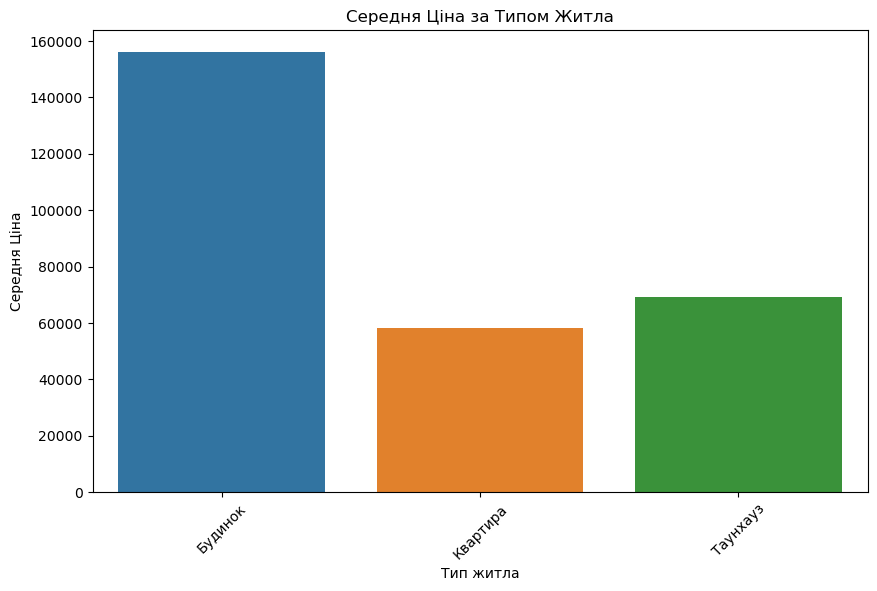

In [26]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


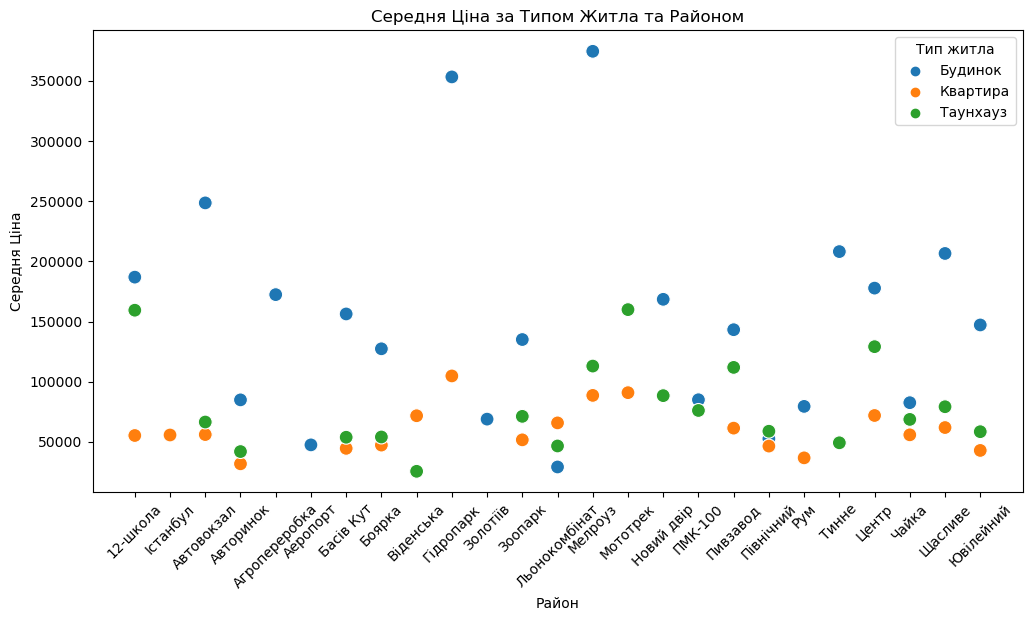

In [27]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

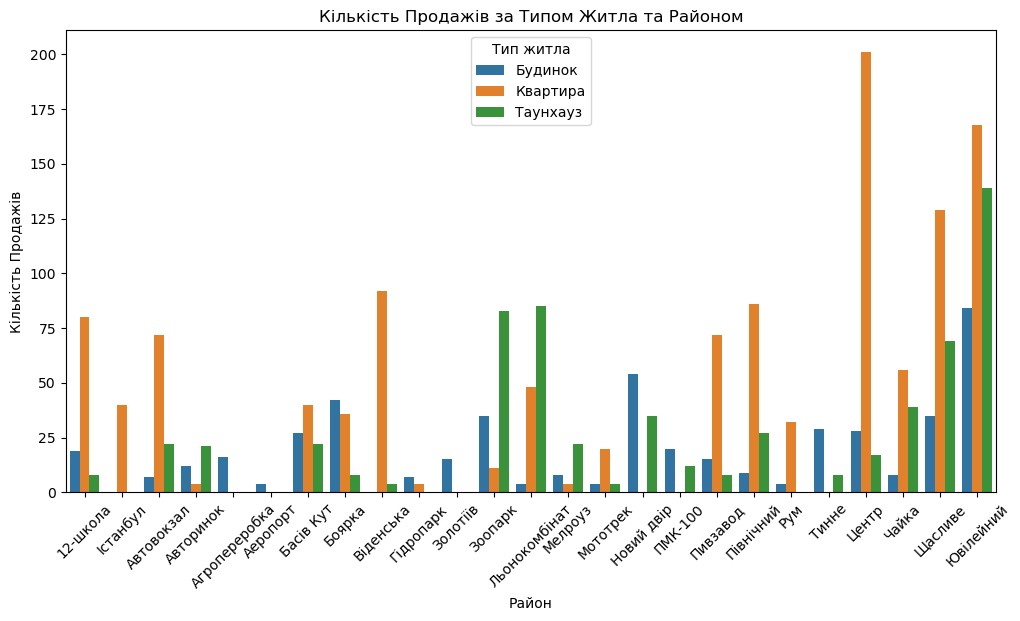

In [28]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


In [3]:
# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# Перегляньте оновлений датасет
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,1 новий / 2 вторични й ринок,к-сть поверхів будинку,Ціна в $/м²,Своя Парковка (1-є 0-не має),Земельний участок (соток),Вартість,Рік пропозиції купівлі нерухомості
0,12-школа,3,59,3,2,1,1644,1,4,96996,2023
1,12-школа,3,90,2,2,1,1500,1,6,135000,2023
2,12-школа,2,151,3,2,2,1656,1,4,250056,2023
3,12-школа,3,240,4,2,2,1417,1,7,340080,2023
4,12-школа,3,90,2,2,1,1500,1,6,135000,2023


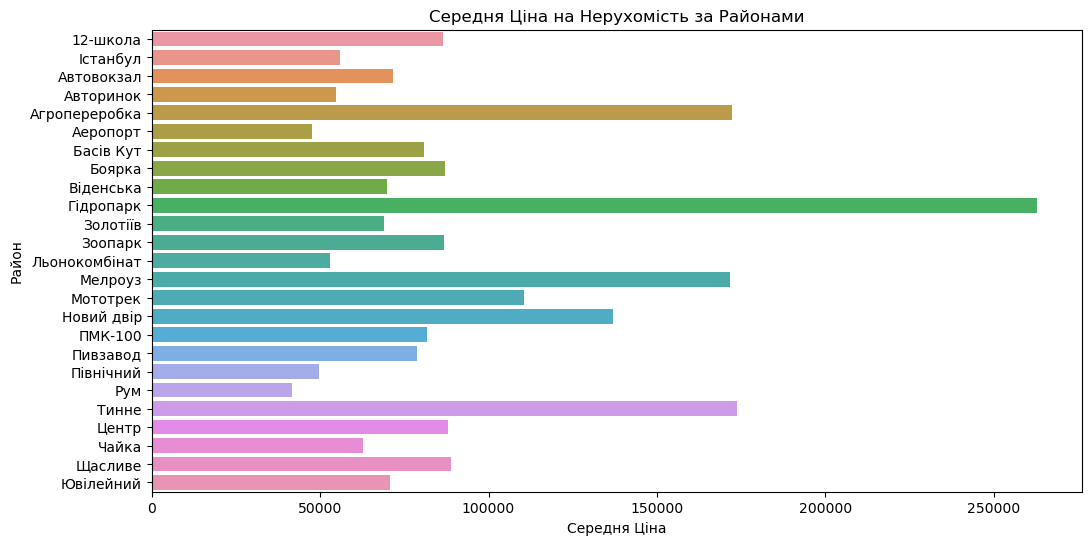

In [30]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [5]:
# Переводимо категоріальні ознаки стовпчика "Район" треба перевести в числовий формат. 
# Для цього використовуємо One-Hot Encoding
df = pd.get_dummies(df, columns=['Район'])

In [58]:
# Пробуємо створити модель лінійної регресії
model = LinearRegression()

# Тренування моделі на навчальних даних
model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
accuracy = model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Linear Regression: {accuracy}')

y_pred_linear = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (MSE) of Linear Regression: {mse_linear}')


Accuracy (R-squared) of Linear Regression: 0.9039820811357304
Mean Squared Error (MSE) of Linear Regression: 617262954.4857326


In [59]:
# Пробуємо використовувати ансамблі, створимо модель випадкового лісу
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Тренування моделі на навчальних даних
rf_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
rf_accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Random Forest: {rf_accuracy}')

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) of Random Forest: {mse_rf}')

Accuracy (R-squared) of Random Forest: 0.998018348467225
Mean Squared Error (MSE) of Random Forest: 12739289.648747522


In [55]:
# Тепер пробуємо градієнтний бустинг:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Тренування моделі на навчальних даних
gb_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
gb_accuracy = gb_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Gradient Boosting: {gb_accuracy}')

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (MSE) of Gradient Boosting: {mse_gb}')

Accuracy (R-squared) of Gradient Boosting: 0.992232792935521
Mean Squared Error (MSE) of Gradient Boosting: 49932442.167384416


In [6]:
# тепер пробуємо створити та навчати модель нейроної мережі для задачі регресії та подивимось на результати

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# Створення та компіляція (модель створена за допомогою класу Sequential тобто шари попорядку)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Навчання моделі (я підберав різну кількість епох, найкращі результати при 10 тис. так й )
model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_split=0.2)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

Epoch 1/10000
47/47 [==============================] - 0s 2ms/step - loss: 13440260096.0000 - val_loss: 8739745792.0000
Epoch 2/10000
47/47 [==============================] - 0s 824us/step - loss: 13438054400.0000 - val_loss: 8736787456.0000
Epoch 3/10000
47/47 [==============================] - 0s 785us/step - loss: 13432202240.0000 - val_loss: 8729583616.0000
Epoch 4/10000
47/47 [==============================] - 0s 807us/step - loss: 13419026432.0000 - val_loss: 8715400192.0000
Epoch 5/10000
47/47 [==============================] - 0s 799us/step - loss: 13394625536.0000 - val_loss: 8691180544.0000
Epoch 6/10000
47/47 [==============================] - 0s 803us/step - loss: 13355239424.0000 - val_loss: 8654321664.0000
Epoch 7/10000
47/47 [==============================] - 0s 796us/step - loss: 13296816128.0000 - val_loss: 8600577024.0000
Epoch 8/10000
47/47 [==============================] - 0s 810us/step - loss: 13215137792.0000 - val_loss: 8529386496.0000
Epoch 9/10000
47/47 [=====

47/47 [==============================] - 0s 759us/step - loss: 1236975872.0000 - val_loss: 918909760.0000
Epoch 69/10000
47/47 [==============================] - 0s 781us/step - loss: 1214559616.0000 - val_loss: 905638976.0000
Epoch 70/10000
47/47 [==============================] - 0s 781us/step - loss: 1193888256.0000 - val_loss: 895907520.0000
Epoch 71/10000
47/47 [==============================] - 0s 836us/step - loss: 1173433984.0000 - val_loss: 884091840.0000
Epoch 72/10000
47/47 [==============================] - 0s 789us/step - loss: 1153858688.0000 - val_loss: 873837440.0000
Epoch 73/10000
47/47 [==============================] - 0s 758us/step - loss: 1133721728.0000 - val_loss: 862688896.0000
Epoch 74/10000
47/47 [==============================] - 0s 779us/step - loss: 1115388928.0000 - val_loss: 853990016.0000
Epoch 75/10000
47/47 [==============================] - 0s 794us/step - loss: 1097160064.0000 - val_loss: 843292800.0000
Epoch 76/10000
47/47 [=========================

Epoch 136/10000
47/47 [==============================] - 0s 747us/step - loss: 502730240.0000 - val_loss: 546910080.0000
Epoch 137/10000
47/47 [==============================] - 0s 760us/step - loss: 498629120.0000 - val_loss: 549420864.0000
Epoch 138/10000
47/47 [==============================] - 0s 747us/step - loss: 494678176.0000 - val_loss: 546286272.0000
Epoch 139/10000
47/47 [==============================] - 0s 751us/step - loss: 491269280.0000 - val_loss: 543232832.0000
Epoch 140/10000
47/47 [==============================] - 0s 743us/step - loss: 486943712.0000 - val_loss: 541416384.0000
Epoch 141/10000
47/47 [==============================] - 0s 773us/step - loss: 483718368.0000 - val_loss: 537864128.0000
Epoch 142/10000
47/47 [==============================] - 0s 761us/step - loss: 480429568.0000 - val_loss: 533639296.0000
Epoch 143/10000
47/47 [==============================] - 0s 765us/step - loss: 476870624.0000 - val_loss: 531200928.0000
Epoch 144/10000
47/47 [=========

47/47 [==============================] - 0s 750us/step - loss: 342580224.0000 - val_loss: 435054656.0000
Epoch 204/10000
47/47 [==============================] - 0s 776us/step - loss: 340557504.0000 - val_loss: 434030720.0000
Epoch 205/10000
47/47 [==============================] - 0s 779us/step - loss: 339367744.0000 - val_loss: 432327776.0000
Epoch 206/10000
47/47 [==============================] - 0s 775us/step - loss: 337284352.0000 - val_loss: 433410400.0000
Epoch 207/10000
47/47 [==============================] - 0s 766us/step - loss: 336049440.0000 - val_loss: 427718464.0000
Epoch 208/10000
47/47 [==============================] - 0s 749us/step - loss: 334059360.0000 - val_loss: 434113216.0000
Epoch 209/10000
47/47 [==============================] - 0s 771us/step - loss: 332358240.0000 - val_loss: 430471200.0000
Epoch 210/10000
47/47 [==============================] - 0s 743us/step - loss: 331207520.0000 - val_loss: 425665120.0000
Epoch 211/10000
47/47 [=========================

Epoch 271/10000
47/47 [==============================] - 0s 757us/step - loss: 238898048.0000 - val_loss: 315706848.0000
Epoch 272/10000
47/47 [==============================] - 0s 765us/step - loss: 237408352.0000 - val_loss: 308653856.0000
Epoch 273/10000
47/47 [==============================] - 0s 769us/step - loss: 236407792.0000 - val_loss: 312305792.0000
Epoch 274/10000
47/47 [==============================] - 0s 744us/step - loss: 234589568.0000 - val_loss: 310064416.0000
Epoch 275/10000
47/47 [==============================] - 0s 772us/step - loss: 233592496.0000 - val_loss: 308768352.0000
Epoch 276/10000
47/47 [==============================] - 0s 747us/step - loss: 232647248.0000 - val_loss: 305343520.0000
Epoch 277/10000
47/47 [==============================] - 0s 797us/step - loss: 231725264.0000 - val_loss: 305437024.0000
Epoch 278/10000
47/47 [==============================] - 0s 765us/step - loss: 231096192.0000 - val_loss: 303204320.0000
Epoch 279/10000
47/47 [=========

47/47 [==============================] - 0s 749us/step - loss: 183115440.0000 - val_loss: 254453296.0000
Epoch 339/10000
47/47 [==============================] - 0s 751us/step - loss: 182643264.0000 - val_loss: 252523040.0000
Epoch 340/10000
47/47 [==============================] - 0s 743us/step - loss: 181959328.0000 - val_loss: 253701408.0000
Epoch 341/10000
47/47 [==============================] - 0s 777us/step - loss: 181255136.0000 - val_loss: 250804368.0000
Epoch 342/10000
47/47 [==============================] - 0s 745us/step - loss: 180812144.0000 - val_loss: 251239712.0000
Epoch 343/10000
47/47 [==============================] - 0s 745us/step - loss: 180263152.0000 - val_loss: 250877984.0000
Epoch 344/10000
47/47 [==============================] - 0s 746us/step - loss: 179696784.0000 - val_loss: 251242064.0000
Epoch 345/10000
47/47 [==============================] - 0s 759us/step - loss: 179015664.0000 - val_loss: 250103216.0000
Epoch 346/10000
47/47 [=========================

Epoch 406/10000
47/47 [==============================] - 0s 745us/step - loss: 151738752.0000 - val_loss: 223744080.0000
Epoch 407/10000
47/47 [==============================] - 0s 745us/step - loss: 151537584.0000 - val_loss: 224624512.0000
Epoch 408/10000
47/47 [==============================] - 0s 759us/step - loss: 150290128.0000 - val_loss: 223502800.0000
Epoch 409/10000
47/47 [==============================] - 0s 787us/step - loss: 149949792.0000 - val_loss: 222780400.0000
Epoch 410/10000
47/47 [==============================] - 0s 750us/step - loss: 149615664.0000 - val_loss: 224485616.0000
Epoch 411/10000
47/47 [==============================] - 0s 750us/step - loss: 149082224.0000 - val_loss: 223107008.0000
Epoch 412/10000
47/47 [==============================] - 0s 758us/step - loss: 148816064.0000 - val_loss: 223594560.0000
Epoch 413/10000
47/47 [==============================] - 0s 748us/step - loss: 148510544.0000 - val_loss: 221890032.0000
Epoch 414/10000
47/47 [=========

47/47 [==============================] - 0s 737us/step - loss: 127656800.0000 - val_loss: 201593520.0000
Epoch 474/10000
47/47 [==============================] - 0s 751us/step - loss: 127529720.0000 - val_loss: 198779936.0000
Epoch 475/10000
47/47 [==============================] - 0s 733us/step - loss: 127078248.0000 - val_loss: 201143968.0000
Epoch 476/10000
47/47 [==============================] - 0s 744us/step - loss: 126925728.0000 - val_loss: 200902592.0000
Epoch 477/10000
47/47 [==============================] - 0s 752us/step - loss: 126538072.0000 - val_loss: 199073232.0000
Epoch 478/10000
47/47 [==============================] - 0s 758us/step - loss: 126772496.0000 - val_loss: 203500688.0000
Epoch 479/10000
47/47 [==============================] - 0s 764us/step - loss: 125995488.0000 - val_loss: 201798080.0000
Epoch 480/10000
47/47 [==============================] - 0s 773us/step - loss: 125977120.0000 - val_loss: 199660544.0000
Epoch 481/10000
47/47 [=========================

Epoch 541/10000
47/47 [==============================] - 0s 751us/step - loss: 110254368.0000 - val_loss: 179728512.0000
Epoch 542/10000
47/47 [==============================] - 0s 753us/step - loss: 109963616.0000 - val_loss: 181395120.0000
Epoch 543/10000
47/47 [==============================] - 0s 748us/step - loss: 109557264.0000 - val_loss: 178677120.0000
Epoch 544/10000
47/47 [==============================] - 0s 766us/step - loss: 109402576.0000 - val_loss: 179139936.0000
Epoch 545/10000
47/47 [==============================] - 0s 760us/step - loss: 109185392.0000 - val_loss: 179178624.0000
Epoch 546/10000
47/47 [==============================] - 0s 763us/step - loss: 109160312.0000 - val_loss: 179495248.0000
Epoch 547/10000
47/47 [==============================] - 0s 778us/step - loss: 108840200.0000 - val_loss: 178420640.0000
Epoch 548/10000
47/47 [==============================] - 0s 748us/step - loss: 108394584.0000 - val_loss: 178409872.0000
Epoch 549/10000
47/47 [=========

Epoch 609/10000
47/47 [==============================] - 0s 751us/step - loss: 96378824.0000 - val_loss: 165343040.0000
Epoch 610/10000
47/47 [==============================] - 0s 731us/step - loss: 96216168.0000 - val_loss: 164179536.0000
Epoch 611/10000
47/47 [==============================] - 0s 751us/step - loss: 95905704.0000 - val_loss: 163012560.0000
Epoch 612/10000
47/47 [==============================] - 0s 750us/step - loss: 96091704.0000 - val_loss: 163434768.0000
Epoch 613/10000
47/47 [==============================] - 0s 753us/step - loss: 95928616.0000 - val_loss: 161720432.0000
Epoch 614/10000
47/47 [==============================] - 0s 744us/step - loss: 95416984.0000 - val_loss: 162722880.0000
Epoch 615/10000
47/47 [==============================] - 0s 756us/step - loss: 95327888.0000 - val_loss: 161945648.0000
Epoch 616/10000
47/47 [==============================] - 0s 788us/step - loss: 95361200.0000 - val_loss: 162281952.0000
Epoch 617/10000
47/47 [=================

47/47 [==============================] - 0s 752us/step - loss: 86161488.0000 - val_loss: 150228848.0000
Epoch 678/10000
47/47 [==============================] - 0s 756us/step - loss: 86123808.0000 - val_loss: 149927264.0000
Epoch 679/10000
47/47 [==============================] - 0s 750us/step - loss: 86071464.0000 - val_loss: 148026912.0000
Epoch 680/10000
47/47 [==============================] - 0s 767us/step - loss: 85890672.0000 - val_loss: 148953232.0000
Epoch 681/10000
47/47 [==============================] - 0s 759us/step - loss: 85705320.0000 - val_loss: 149709888.0000
Epoch 682/10000
47/47 [==============================] - 0s 745us/step - loss: 85440344.0000 - val_loss: 149595440.0000
Epoch 683/10000
47/47 [==============================] - 0s 749us/step - loss: 85610344.0000 - val_loss: 148645936.0000
Epoch 684/10000
47/47 [==============================] - 0s 757us/step - loss: 85396888.0000 - val_loss: 149717024.0000
Epoch 685/10000
47/47 [==============================] -

47/47 [==============================] - 0s 747us/step - loss: 78110056.0000 - val_loss: 139455232.0000
Epoch 746/10000
47/47 [==============================] - 0s 749us/step - loss: 77853200.0000 - val_loss: 137679888.0000
Epoch 747/10000
47/47 [==============================] - 0s 769us/step - loss: 77955768.0000 - val_loss: 138988624.0000
Epoch 748/10000
47/47 [==============================] - 0s 754us/step - loss: 77670408.0000 - val_loss: 138966432.0000
Epoch 749/10000
47/47 [==============================] - 0s 737us/step - loss: 77746696.0000 - val_loss: 137296336.0000
Epoch 750/10000
47/47 [==============================] - 0s 763us/step - loss: 77238144.0000 - val_loss: 139911328.0000
Epoch 751/10000
47/47 [==============================] - 0s 763us/step - loss: 77316376.0000 - val_loss: 138651520.0000
Epoch 752/10000
47/47 [==============================] - 0s 754us/step - loss: 77158136.0000 - val_loss: 137272224.0000
Epoch 753/10000
47/47 [==============================] -

47/47 [==============================] - 0s 944us/step - loss: 71034248.0000 - val_loss: 128033120.0000
Epoch 814/10000
47/47 [==============================] - 0s 908us/step - loss: 71151432.0000 - val_loss: 128041248.0000
Epoch 815/10000
47/47 [==============================] - 0s 929us/step - loss: 70874192.0000 - val_loss: 126499208.0000
Epoch 816/10000
47/47 [==============================] - 0s 934us/step - loss: 71173176.0000 - val_loss: 126906592.0000
Epoch 817/10000
47/47 [==============================] - 0s 897us/step - loss: 70723776.0000 - val_loss: 126867352.0000
Epoch 818/10000
47/47 [==============================] - 0s 890us/step - loss: 71054032.0000 - val_loss: 127325840.0000
Epoch 819/10000
47/47 [==============================] - 0s 893us/step - loss: 70727616.0000 - val_loss: 127679840.0000
Epoch 820/10000
47/47 [==============================] - 0s 777us/step - loss: 70606464.0000 - val_loss: 127249888.0000
Epoch 821/10000
47/47 [==============================] -

47/47 [==============================] - 0s 761us/step - loss: 65762504.0000 - val_loss: 119816632.0000
Epoch 882/10000
47/47 [==============================] - 0s 757us/step - loss: 65593992.0000 - val_loss: 120697216.0000
Epoch 883/10000
47/47 [==============================] - 0s 758us/step - loss: 65450776.0000 - val_loss: 118617144.0000
Epoch 884/10000
47/47 [==============================] - 0s 756us/step - loss: 65671164.0000 - val_loss: 118630440.0000
Epoch 885/10000
47/47 [==============================] - 0s 728us/step - loss: 65690720.0000 - val_loss: 117614248.0000
Epoch 886/10000
47/47 [==============================] - 0s 764us/step - loss: 65266188.0000 - val_loss: 118771920.0000
Epoch 887/10000
47/47 [==============================] - 0s 756us/step - loss: 65148352.0000 - val_loss: 119030432.0000
Epoch 888/10000
47/47 [==============================] - 0s 735us/step - loss: 65131712.0000 - val_loss: 118236424.0000
Epoch 889/10000
47/47 [==============================] -

47/47 [==============================] - 0s 775us/step - loss: 60834820.0000 - val_loss: 112271640.0000
Epoch 950/10000
47/47 [==============================] - 0s 728us/step - loss: 60838108.0000 - val_loss: 112312296.0000
Epoch 951/10000
47/47 [==============================] - 0s 743us/step - loss: 60859772.0000 - val_loss: 112455008.0000
Epoch 952/10000
47/47 [==============================] - 0s 730us/step - loss: 60630748.0000 - val_loss: 112538000.0000
Epoch 953/10000
47/47 [==============================] - 0s 763us/step - loss: 60562068.0000 - val_loss: 111367808.0000
Epoch 954/10000
47/47 [==============================] - 0s 754us/step - loss: 60583372.0000 - val_loss: 112087904.0000
Epoch 955/10000
47/47 [==============================] - 0s 759us/step - loss: 60702232.0000 - val_loss: 113526136.0000
Epoch 956/10000
47/47 [==============================] - 0s 744us/step - loss: 60504060.0000 - val_loss: 113090696.0000
Epoch 957/10000
47/47 [==============================] -

47/47 [==============================] - 0s 955us/step - loss: 55950568.0000 - val_loss: 104499976.0000
Epoch 1018/10000
47/47 [==============================] - 0s 948us/step - loss: 55980864.0000 - val_loss: 104557784.0000
Epoch 1019/10000
47/47 [==============================] - 0s 964us/step - loss: 55921496.0000 - val_loss: 105308184.0000
Epoch 1020/10000
47/47 [==============================] - 0s 971us/step - loss: 55728516.0000 - val_loss: 104322368.0000
Epoch 1021/10000
47/47 [==============================] - 0s 1ms/step - loss: 55675688.0000 - val_loss: 104919992.0000
Epoch 1022/10000
47/47 [==============================] - 0s 968us/step - loss: 55672744.0000 - val_loss: 103840912.0000
Epoch 1023/10000
47/47 [==============================] - 0s 949us/step - loss: 55525204.0000 - val_loss: 104650472.0000
Epoch 1024/10000
47/47 [==============================] - 0s 954us/step - loss: 55260852.0000 - val_loss: 104489184.0000
Epoch 1025/10000
47/47 [===========================

47/47 [==============================] - 0s 740us/step - loss: 49703840.0000 - val_loss: 94789600.0000
Epoch 1086/10000
47/47 [==============================] - 0s 747us/step - loss: 49624204.0000 - val_loss: 94975608.0000
Epoch 1087/10000
47/47 [==============================] - 0s 769us/step - loss: 49479000.0000 - val_loss: 95098352.0000
Epoch 1088/10000
47/47 [==============================] - 0s 742us/step - loss: 49490396.0000 - val_loss: 94858112.0000
Epoch 1089/10000
47/47 [==============================] - 0s 736us/step - loss: 49343060.0000 - val_loss: 94605232.0000
Epoch 1090/10000
47/47 [==============================] - 0s 759us/step - loss: 49214724.0000 - val_loss: 94569112.0000
Epoch 1091/10000
47/47 [==============================] - 0s 746us/step - loss: 49152652.0000 - val_loss: 95155888.0000
Epoch 1092/10000
47/47 [==============================] - 0s 762us/step - loss: 49039184.0000 - val_loss: 94772632.0000
Epoch 1093/10000
47/47 [==============================] -

47/47 [==============================] - 0s 761us/step - loss: 42458520.0000 - val_loss: 83672648.0000
Epoch 1154/10000
47/47 [==============================] - 0s 776us/step - loss: 42363908.0000 - val_loss: 84452080.0000
Epoch 1155/10000
47/47 [==============================] - 0s 746us/step - loss: 42355988.0000 - val_loss: 85544792.0000
Epoch 1156/10000
47/47 [==============================] - 0s 741us/step - loss: 41950956.0000 - val_loss: 83628992.0000
Epoch 1157/10000
47/47 [==============================] - 0s 772us/step - loss: 41953088.0000 - val_loss: 82334344.0000
Epoch 1158/10000
47/47 [==============================] - 0s 763us/step - loss: 41969724.0000 - val_loss: 83027976.0000
Epoch 1159/10000
47/47 [==============================] - 0s 751us/step - loss: 41706320.0000 - val_loss: 82456136.0000
Epoch 1160/10000
47/47 [==============================] - 0s 751us/step - loss: 41653204.0000 - val_loss: 81909600.0000
Epoch 1161/10000
47/47 [==============================] -

47/47 [==============================] - 0s 779us/step - loss: 34397568.0000 - val_loss: 71237088.0000
Epoch 1222/10000
47/47 [==============================] - 0s 761us/step - loss: 34235576.0000 - val_loss: 71816384.0000
Epoch 1223/10000
47/47 [==============================] - 0s 767us/step - loss: 34091260.0000 - val_loss: 70481784.0000
Epoch 1224/10000
47/47 [==============================] - 0s 753us/step - loss: 34280956.0000 - val_loss: 70855248.0000
Epoch 1225/10000
47/47 [==============================] - 0s 751us/step - loss: 34047556.0000 - val_loss: 69602512.0000
Epoch 1226/10000
47/47 [==============================] - 0s 779us/step - loss: 33862988.0000 - val_loss: 70614544.0000
Epoch 1227/10000
47/47 [==============================] - 0s 769us/step - loss: 33794800.0000 - val_loss: 70379504.0000
Epoch 1228/10000
47/47 [==============================] - 0s 765us/step - loss: 33702460.0000 - val_loss: 71301232.0000
Epoch 1229/10000
47/47 [==============================] -

47/47 [==============================] - 0s 764us/step - loss: 27229478.0000 - val_loss: 59192632.0000
Epoch 1290/10000
47/47 [==============================] - 0s 755us/step - loss: 27150244.0000 - val_loss: 59911956.0000
Epoch 1291/10000
47/47 [==============================] - 0s 755us/step - loss: 27116788.0000 - val_loss: 59542332.0000
Epoch 1292/10000
47/47 [==============================] - 0s 768us/step - loss: 26973982.0000 - val_loss: 58866752.0000
Epoch 1293/10000
47/47 [==============================] - 0s 787us/step - loss: 26878146.0000 - val_loss: 58832428.0000
Epoch 1294/10000
47/47 [==============================] - 0s 781us/step - loss: 26763128.0000 - val_loss: 58620516.0000
Epoch 1295/10000
47/47 [==============================] - 0s 752us/step - loss: 26668318.0000 - val_loss: 58613104.0000
Epoch 1296/10000
47/47 [==============================] - 0s 757us/step - loss: 26629334.0000 - val_loss: 57612160.0000
Epoch 1297/10000
47/47 [==============================] -

47/47 [==============================] - 0s 754us/step - loss: 21558982.0000 - val_loss: 49423688.0000
Epoch 1358/10000
47/47 [==============================] - 0s 776us/step - loss: 21602648.0000 - val_loss: 49423892.0000
Epoch 1359/10000
47/47 [==============================] - 0s 753us/step - loss: 21578472.0000 - val_loss: 47839712.0000
Epoch 1360/10000
47/47 [==============================] - 0s 771us/step - loss: 21315632.0000 - val_loss: 49465828.0000
Epoch 1361/10000
47/47 [==============================] - 0s 746us/step - loss: 21350474.0000 - val_loss: 47928396.0000
Epoch 1362/10000
47/47 [==============================] - 0s 750us/step - loss: 21449954.0000 - val_loss: 50204108.0000
Epoch 1363/10000
47/47 [==============================] - 0s 763us/step - loss: 21307780.0000 - val_loss: 49023048.0000
Epoch 1364/10000
47/47 [==============================] - 0s 742us/step - loss: 21162072.0000 - val_loss: 48636612.0000
Epoch 1365/10000
47/47 [==============================] -

47/47 [==============================] - 0s 758us/step - loss: 17708306.0000 - val_loss: 42274784.0000
Epoch 1426/10000
47/47 [==============================] - 0s 758us/step - loss: 17855168.0000 - val_loss: 42514904.0000
Epoch 1427/10000
47/47 [==============================] - 0s 769us/step - loss: 17734720.0000 - val_loss: 40563272.0000
Epoch 1428/10000
47/47 [==============================] - 0s 746us/step - loss: 17530792.0000 - val_loss: 41436584.0000
Epoch 1429/10000
47/47 [==============================] - 0s 760us/step - loss: 17403944.0000 - val_loss: 40846236.0000
Epoch 1430/10000
47/47 [==============================] - 0s 774us/step - loss: 17377908.0000 - val_loss: 40971776.0000
Epoch 1431/10000
47/47 [==============================] - 0s 756us/step - loss: 17468222.0000 - val_loss: 40887100.0000
Epoch 1432/10000
47/47 [==============================] - 0s 758us/step - loss: 17550608.0000 - val_loss: 40653444.0000
Epoch 1433/10000
47/47 [==============================] -

47/47 [==============================] - 0s 744us/step - loss: 14695421.0000 - val_loss: 36942736.0000
Epoch 1494/10000
47/47 [==============================] - 0s 768us/step - loss: 14760730.0000 - val_loss: 36378448.0000
Epoch 1495/10000
47/47 [==============================] - 0s 757us/step - loss: 14706056.0000 - val_loss: 37158008.0000
Epoch 1496/10000
47/47 [==============================] - 0s 753us/step - loss: 14679903.0000 - val_loss: 36330040.0000
Epoch 1497/10000
47/47 [==============================] - 0s 760us/step - loss: 14542675.0000 - val_loss: 36230192.0000
Epoch 1498/10000
47/47 [==============================] - 0s 754us/step - loss: 14501786.0000 - val_loss: 36023712.0000
Epoch 1499/10000
47/47 [==============================] - 0s 755us/step - loss: 14548697.0000 - val_loss: 36793884.0000
Epoch 1500/10000
47/47 [==============================] - 0s 759us/step - loss: 14422226.0000 - val_loss: 36377176.0000
Epoch 1501/10000
47/47 [==============================] -

47/47 [==============================] - 0s 764us/step - loss: 12638261.0000 - val_loss: 34542204.0000
Epoch 1562/10000
47/47 [==============================] - 0s 782us/step - loss: 12645874.0000 - val_loss: 33667488.0000
Epoch 1563/10000
47/47 [==============================] - 0s 758us/step - loss: 12509018.0000 - val_loss: 33780856.0000
Epoch 1564/10000
47/47 [==============================] - 0s 764us/step - loss: 12623873.0000 - val_loss: 32248374.0000
Epoch 1565/10000
47/47 [==============================] - 0s 756us/step - loss: 12685035.0000 - val_loss: 31794844.0000
Epoch 1566/10000
47/47 [==============================] - 0s 758us/step - loss: 12462492.0000 - val_loss: 33347040.0000
Epoch 1567/10000
47/47 [==============================] - 0s 746us/step - loss: 12373022.0000 - val_loss: 32538580.0000
Epoch 1568/10000
47/47 [==============================] - 0s 771us/step - loss: 12392764.0000 - val_loss: 32878374.0000
Epoch 1569/10000
47/47 [==============================] -

47/47 [==============================] - 0s 735us/step - loss: 10903218.0000 - val_loss: 30993036.0000
Epoch 1630/10000
47/47 [==============================] - 0s 736us/step - loss: 10903114.0000 - val_loss: 30601472.0000
Epoch 1631/10000
47/47 [==============================] - 0s 760us/step - loss: 10776101.0000 - val_loss: 31240692.0000
Epoch 1632/10000
47/47 [==============================] - 0s 758us/step - loss: 10871194.0000 - val_loss: 29859388.0000
Epoch 1633/10000
47/47 [==============================] - 0s 752us/step - loss: 10782822.0000 - val_loss: 31181986.0000
Epoch 1634/10000
47/47 [==============================] - 0s 755us/step - loss: 10869352.0000 - val_loss: 30866844.0000
Epoch 1635/10000
47/47 [==============================] - 0s 757us/step - loss: 10865340.0000 - val_loss: 29513750.0000
Epoch 1636/10000
47/47 [==============================] - 0s 746us/step - loss: 10754900.0000 - val_loss: 31318678.0000
Epoch 1637/10000
47/47 [==============================] -

47/47 [==============================] - 0s 757us/step - loss: 9529581.0000 - val_loss: 30150148.0000
Epoch 1698/10000
47/47 [==============================] - 0s 751us/step - loss: 9410807.0000 - val_loss: 29092434.0000
Epoch 1699/10000
47/47 [==============================] - 0s 772us/step - loss: 9449354.0000 - val_loss: 29433706.0000
Epoch 1700/10000
47/47 [==============================] - 0s 754us/step - loss: 9416833.0000 - val_loss: 28779986.0000
Epoch 1701/10000
47/47 [==============================] - 0s 754us/step - loss: 9420268.0000 - val_loss: 28328110.0000
Epoch 1702/10000
47/47 [==============================] - 0s 766us/step - loss: 9420155.0000 - val_loss: 29076748.0000
Epoch 1703/10000
47/47 [==============================] - 0s 751us/step - loss: 9290038.0000 - val_loss: 29625650.0000
Epoch 1704/10000
47/47 [==============================] - 0s 764us/step - loss: 9283917.0000 - val_loss: 29326502.0000
Epoch 1705/10000
47/47 [==============================] - 0s 764u

Epoch 1766/10000
47/47 [==============================] - 0s 741us/step - loss: 8411741.0000 - val_loss: 27520806.0000
Epoch 1767/10000
47/47 [==============================] - 0s 748us/step - loss: 8363178.0000 - val_loss: 27500182.0000
Epoch 1768/10000
47/47 [==============================] - 0s 757us/step - loss: 8270261.5000 - val_loss: 27275998.0000
Epoch 1769/10000
47/47 [==============================] - 0s 770us/step - loss: 8242686.0000 - val_loss: 27087000.0000
Epoch 1770/10000
47/47 [==============================] - 0s 759us/step - loss: 8197818.0000 - val_loss: 27844034.0000
Epoch 1771/10000
47/47 [==============================] - 0s 747us/step - loss: 8182744.0000 - val_loss: 27680308.0000
Epoch 1772/10000
47/47 [==============================] - 0s 762us/step - loss: 8146818.0000 - val_loss: 27978628.0000
Epoch 1773/10000
47/47 [==============================] - 0s 747us/step - loss: 8192894.0000 - val_loss: 26995864.0000
Epoch 1774/10000
47/47 [========================

Epoch 1835/10000
47/47 [==============================] - 0s 746us/step - loss: 7326292.5000 - val_loss: 26231016.0000
Epoch 1836/10000
47/47 [==============================] - 0s 740us/step - loss: 7366314.0000 - val_loss: 25702936.0000
Epoch 1837/10000
47/47 [==============================] - 0s 757us/step - loss: 7382614.0000 - val_loss: 25843828.0000
Epoch 1838/10000
47/47 [==============================] - 0s 764us/step - loss: 7371693.5000 - val_loss: 25329216.0000
Epoch 1839/10000
47/47 [==============================] - 0s 767us/step - loss: 7340378.5000 - val_loss: 25732458.0000
Epoch 1840/10000
47/47 [==============================] - 0s 763us/step - loss: 7280672.5000 - val_loss: 26555492.0000
Epoch 1841/10000
47/47 [==============================] - 0s 764us/step - loss: 7303797.5000 - val_loss: 26681346.0000
Epoch 1842/10000
47/47 [==============================] - 0s 776us/step - loss: 7205675.5000 - val_loss: 26209054.0000
Epoch 1843/10000
47/47 [========================

Epoch 1904/10000
47/47 [==============================] - 0s 771us/step - loss: 6554372.0000 - val_loss: 24905422.0000
Epoch 1905/10000
47/47 [==============================] - 0s 756us/step - loss: 6520453.5000 - val_loss: 25268734.0000
Epoch 1906/10000
47/47 [==============================] - 0s 765us/step - loss: 6534057.0000 - val_loss: 25099904.0000
Epoch 1907/10000
47/47 [==============================] - 0s 750us/step - loss: 6513401.0000 - val_loss: 24779662.0000
Epoch 1908/10000
47/47 [==============================] - 0s 751us/step - loss: 6502266.0000 - val_loss: 25731498.0000
Epoch 1909/10000
47/47 [==============================] - 0s 758us/step - loss: 6603491.0000 - val_loss: 25605340.0000
Epoch 1910/10000
47/47 [==============================] - 0s 762us/step - loss: 6543722.5000 - val_loss: 24685116.0000
Epoch 1911/10000
47/47 [==============================] - 0s 752us/step - loss: 6460416.0000 - val_loss: 25052822.0000
Epoch 1912/10000
47/47 [========================

Epoch 1973/10000
47/47 [==============================] - 0s 752us/step - loss: 5913293.5000 - val_loss: 23932458.0000
Epoch 1974/10000
47/47 [==============================] - 0s 747us/step - loss: 5852814.5000 - val_loss: 23399614.0000
Epoch 1975/10000
47/47 [==============================] - 0s 744us/step - loss: 5831191.5000 - val_loss: 23867492.0000
Epoch 1976/10000
47/47 [==============================] - 0s 763us/step - loss: 5856461.0000 - val_loss: 24374084.0000
Epoch 1977/10000
47/47 [==============================] - 0s 752us/step - loss: 5831774.0000 - val_loss: 23812084.0000
Epoch 1978/10000
47/47 [==============================] - 0s 769us/step - loss: 5852716.5000 - val_loss: 23338660.0000
Epoch 1979/10000
47/47 [==============================] - 0s 739us/step - loss: 5820093.0000 - val_loss: 23563356.0000
Epoch 1980/10000
47/47 [==============================] - 0s 757us/step - loss: 5804089.5000 - val_loss: 23543052.0000
Epoch 1981/10000
47/47 [========================

Epoch 2042/10000
47/47 [==============================] - 0s 735us/step - loss: 5318099.0000 - val_loss: 22396360.0000
Epoch 2043/10000
47/47 [==============================] - 0s 759us/step - loss: 5239702.5000 - val_loss: 23336948.0000
Epoch 2044/10000
47/47 [==============================] - 0s 752us/step - loss: 5272815.0000 - val_loss: 22911454.0000
Epoch 2045/10000
47/47 [==============================] - 0s 745us/step - loss: 5242457.5000 - val_loss: 22731036.0000
Epoch 2046/10000
47/47 [==============================] - 0s 756us/step - loss: 5259510.5000 - val_loss: 22338136.0000
Epoch 2047/10000
47/47 [==============================] - 0s 751us/step - loss: 5280640.5000 - val_loss: 22380894.0000
Epoch 2048/10000
47/47 [==============================] - 0s 735us/step - loss: 5338729.0000 - val_loss: 22419058.0000
Epoch 2049/10000
47/47 [==============================] - 0s 758us/step - loss: 5214585.5000 - val_loss: 22005534.0000
Epoch 2050/10000
47/47 [========================

Epoch 2111/10000
47/47 [==============================] - 0s 758us/step - loss: 4764382.0000 - val_loss: 20973748.0000
Epoch 2112/10000
47/47 [==============================] - 0s 773us/step - loss: 4808178.0000 - val_loss: 21649696.0000
Epoch 2113/10000
47/47 [==============================] - 0s 751us/step - loss: 4736680.0000 - val_loss: 21668964.0000
Epoch 2114/10000
47/47 [==============================] - 0s 758us/step - loss: 4764138.0000 - val_loss: 21593952.0000
Epoch 2115/10000
47/47 [==============================] - 0s 764us/step - loss: 4782982.0000 - val_loss: 22155074.0000
Epoch 2116/10000
47/47 [==============================] - 0s 745us/step - loss: 4765460.0000 - val_loss: 21968274.0000
Epoch 2117/10000
47/47 [==============================] - 0s 753us/step - loss: 4783063.0000 - val_loss: 21767490.0000
Epoch 2118/10000
47/47 [==============================] - 0s 743us/step - loss: 4812996.5000 - val_loss: 21194148.0000
Epoch 2119/10000
47/47 [========================

Epoch 2180/10000
47/47 [==============================] - 0s 758us/step - loss: 4377751.0000 - val_loss: 20994432.0000
Epoch 2181/10000
47/47 [==============================] - 0s 769us/step - loss: 4376463.0000 - val_loss: 20960780.0000
Epoch 2182/10000
47/47 [==============================] - 0s 764us/step - loss: 4353916.0000 - val_loss: 20083390.0000
Epoch 2183/10000
47/47 [==============================] - 0s 769us/step - loss: 4346854.0000 - val_loss: 20984590.0000
Epoch 2184/10000
47/47 [==============================] - 0s 763us/step - loss: 4337873.0000 - val_loss: 20457294.0000
Epoch 2185/10000
47/47 [==============================] - 0s 755us/step - loss: 4381019.0000 - val_loss: 21345206.0000
Epoch 2186/10000
47/47 [==============================] - 0s 763us/step - loss: 4372416.5000 - val_loss: 21089680.0000
Epoch 2187/10000
47/47 [==============================] - 0s 751us/step - loss: 4307079.5000 - val_loss: 20850294.0000
Epoch 2188/10000
47/47 [========================

Epoch 2249/10000
47/47 [==============================] - 0s 755us/step - loss: 3832049.5000 - val_loss: 19366764.0000
Epoch 2250/10000
47/47 [==============================] - 0s 760us/step - loss: 3867508.2500 - val_loss: 20065366.0000
Epoch 2251/10000
47/47 [==============================] - 0s 747us/step - loss: 3834938.7500 - val_loss: 19153314.0000
Epoch 2252/10000
47/47 [==============================] - 0s 757us/step - loss: 3825875.7500 - val_loss: 19785820.0000
Epoch 2253/10000
47/47 [==============================] - 0s 770us/step - loss: 3841645.2500 - val_loss: 19671518.0000
Epoch 2254/10000
47/47 [==============================] - 0s 757us/step - loss: 3875874.0000 - val_loss: 19738170.0000
Epoch 2255/10000
47/47 [==============================] - 0s 749us/step - loss: 3838224.5000 - val_loss: 20044272.0000
Epoch 2256/10000
47/47 [==============================] - 0s 767us/step - loss: 3798415.2500 - val_loss: 19612012.0000
Epoch 2257/10000
47/47 [========================

Epoch 2318/10000
47/47 [==============================] - 0s 757us/step - loss: 3461814.7500 - val_loss: 19261448.0000
Epoch 2319/10000
47/47 [==============================] - 0s 763us/step - loss: 3498302.0000 - val_loss: 18688362.0000
Epoch 2320/10000
47/47 [==============================] - 0s 742us/step - loss: 3440811.0000 - val_loss: 18543964.0000
Epoch 2321/10000
47/47 [==============================] - 0s 762us/step - loss: 3485146.7500 - val_loss: 18522530.0000
Epoch 2322/10000
47/47 [==============================] - 0s 768us/step - loss: 3569100.0000 - val_loss: 19094368.0000
Epoch 2323/10000
47/47 [==============================] - 0s 764us/step - loss: 3449436.7500 - val_loss: 18550974.0000
Epoch 2324/10000
47/47 [==============================] - 0s 754us/step - loss: 3404676.2500 - val_loss: 18664272.0000
Epoch 2325/10000
47/47 [==============================] - 0s 758us/step - loss: 3400001.7500 - val_loss: 19124944.0000
Epoch 2326/10000
47/47 [========================

Epoch 2387/10000
47/47 [==============================] - 0s 749us/step - loss: 3104505.0000 - val_loss: 17312336.0000
Epoch 2388/10000
47/47 [==============================] - 0s 764us/step - loss: 3165382.0000 - val_loss: 17410620.0000
Epoch 2389/10000
47/47 [==============================] - 0s 773us/step - loss: 3260076.0000 - val_loss: 17630262.0000
Epoch 2390/10000
47/47 [==============================] - 0s 762us/step - loss: 3153053.7500 - val_loss: 17704850.0000
Epoch 2391/10000
47/47 [==============================] - 0s 745us/step - loss: 3119921.5000 - val_loss: 18091922.0000
Epoch 2392/10000
47/47 [==============================] - 0s 749us/step - loss: 3113487.5000 - val_loss: 17589084.0000
Epoch 2393/10000
47/47 [==============================] - 0s 763us/step - loss: 3152817.0000 - val_loss: 18313774.0000
Epoch 2394/10000
47/47 [==============================] - 0s 768us/step - loss: 3089180.0000 - val_loss: 17364504.0000
Epoch 2395/10000
47/47 [========================

Epoch 2456/10000
47/47 [==============================] - 0s 757us/step - loss: 2812370.5000 - val_loss: 17300866.0000
Epoch 2457/10000
47/47 [==============================] - 0s 743us/step - loss: 2817649.0000 - val_loss: 17548050.0000
Epoch 2458/10000
47/47 [==============================] - 0s 756us/step - loss: 2824445.7500 - val_loss: 16707940.0000
Epoch 2459/10000
47/47 [==============================] - 0s 762us/step - loss: 2887803.2500 - val_loss: 17072704.0000
Epoch 2460/10000
47/47 [==============================] - 0s 746us/step - loss: 2891374.7500 - val_loss: 17467328.0000
Epoch 2461/10000
47/47 [==============================] - 0s 762us/step - loss: 2884181.0000 - val_loss: 17073630.0000
Epoch 2462/10000
47/47 [==============================] - 0s 750us/step - loss: 2850875.0000 - val_loss: 17631786.0000
Epoch 2463/10000
47/47 [==============================] - 0s 767us/step - loss: 2804099.7500 - val_loss: 16529473.0000
Epoch 2464/10000
47/47 [========================

Epoch 2525/10000
47/47 [==============================] - 0s 756us/step - loss: 2603340.2500 - val_loss: 16805992.0000
Epoch 2526/10000
47/47 [==============================] - 0s 760us/step - loss: 2603923.7500 - val_loss: 16672360.0000
Epoch 2527/10000
47/47 [==============================] - 0s 723us/step - loss: 2560729.5000 - val_loss: 17584034.0000
Epoch 2528/10000
47/47 [==============================] - 0s 767us/step - loss: 2630257.7500 - val_loss: 17108260.0000
Epoch 2529/10000
47/47 [==============================] - 0s 745us/step - loss: 2617035.0000 - val_loss: 17715040.0000
Epoch 2530/10000
47/47 [==============================] - 0s 755us/step - loss: 2635739.2500 - val_loss: 17682622.0000
Epoch 2531/10000
47/47 [==============================] - 0s 752us/step - loss: 2606850.0000 - val_loss: 17999140.0000
Epoch 2532/10000
47/47 [==============================] - 0s 769us/step - loss: 2618867.5000 - val_loss: 17270948.0000
Epoch 2533/10000
47/47 [========================

Epoch 2594/10000
47/47 [==============================] - 0s 753us/step - loss: 2349629.5000 - val_loss: 16052565.0000
Epoch 2595/10000
47/47 [==============================] - 0s 766us/step - loss: 2351016.7500 - val_loss: 16058118.0000
Epoch 2596/10000
47/47 [==============================] - 0s 744us/step - loss: 2355833.7500 - val_loss: 16678687.0000
Epoch 2597/10000
47/47 [==============================] - 0s 729us/step - loss: 2422511.5000 - val_loss: 15980805.0000
Epoch 2598/10000
47/47 [==============================] - 0s 764us/step - loss: 2346064.0000 - val_loss: 16654025.0000
Epoch 2599/10000
47/47 [==============================] - 0s 773us/step - loss: 2333466.0000 - val_loss: 16308660.0000
Epoch 2600/10000
47/47 [==============================] - 0s 769us/step - loss: 2313141.2500 - val_loss: 16795064.0000
Epoch 2601/10000
47/47 [==============================] - 0s 754us/step - loss: 2340762.0000 - val_loss: 16306002.0000
Epoch 2602/10000
47/47 [========================

Epoch 2663/10000
47/47 [==============================] - 0s 745us/step - loss: 2215233.0000 - val_loss: 16349130.0000
Epoch 2664/10000
47/47 [==============================] - 0s 748us/step - loss: 2192936.7500 - val_loss: 16022594.0000
Epoch 2665/10000
47/47 [==============================] - 0s 752us/step - loss: 2176418.0000 - val_loss: 15851196.0000
Epoch 2666/10000
47/47 [==============================] - 0s 756us/step - loss: 2155676.0000 - val_loss: 15802684.0000
Epoch 2667/10000
47/47 [==============================] - 0s 742us/step - loss: 2187276.5000 - val_loss: 16177105.0000
Epoch 2668/10000
47/47 [==============================] - 0s 754us/step - loss: 2174395.7500 - val_loss: 16420845.0000
Epoch 2669/10000
47/47 [==============================] - 0s 743us/step - loss: 2161719.7500 - val_loss: 15684850.0000
Epoch 2670/10000
47/47 [==============================] - 0s 762us/step - loss: 2135285.0000 - val_loss: 16119871.0000
Epoch 2671/10000
47/47 [========================

Epoch 2732/10000
47/47 [==============================] - 0s 741us/step - loss: 1967396.6250 - val_loss: 16025385.0000
Epoch 2733/10000
47/47 [==============================] - 0s 772us/step - loss: 1991987.7500 - val_loss: 15390883.0000
Epoch 2734/10000
47/47 [==============================] - 0s 778us/step - loss: 1998982.8750 - val_loss: 16633612.0000
Epoch 2735/10000
47/47 [==============================] - 0s 767us/step - loss: 1992835.2500 - val_loss: 16199525.0000
Epoch 2736/10000
47/47 [==============================] - 0s 748us/step - loss: 1987427.0000 - val_loss: 16627473.0000
Epoch 2737/10000
47/47 [==============================] - 0s 774us/step - loss: 2012306.0000 - val_loss: 16217811.0000
Epoch 2738/10000
47/47 [==============================] - 0s 775us/step - loss: 2072438.1250 - val_loss: 16028280.0000
Epoch 2739/10000
47/47 [==============================] - 0s 766us/step - loss: 2010743.3750 - val_loss: 16245063.0000
Epoch 2740/10000
47/47 [========================

Epoch 2801/10000
47/47 [==============================] - 0s 730us/step - loss: 1859303.6250 - val_loss: 15536256.0000
Epoch 2802/10000
47/47 [==============================] - 0s 754us/step - loss: 1833971.7500 - val_loss: 15818831.0000
Epoch 2803/10000
47/47 [==============================] - 0s 758us/step - loss: 1807163.0000 - val_loss: 15864618.0000
Epoch 2804/10000
47/47 [==============================] - 0s 727us/step - loss: 1809738.3750 - val_loss: 15459456.0000
Epoch 2805/10000
47/47 [==============================] - 0s 762us/step - loss: 1836206.8750 - val_loss: 15830427.0000
Epoch 2806/10000
47/47 [==============================] - 0s 768us/step - loss: 1858102.6250 - val_loss: 16142045.0000
Epoch 2807/10000
47/47 [==============================] - 0s 759us/step - loss: 1838308.5000 - val_loss: 15299220.0000
Epoch 2808/10000
47/47 [==============================] - 0s 751us/step - loss: 1899398.2500 - val_loss: 15301095.0000
Epoch 2809/10000
47/47 [========================

Epoch 2870/10000
47/47 [==============================] - 0s 734us/step - loss: 1707283.0000 - val_loss: 15102850.0000
Epoch 2871/10000
47/47 [==============================] - 0s 736us/step - loss: 1722435.0000 - val_loss: 15363245.0000
Epoch 2872/10000
47/47 [==============================] - 0s 762us/step - loss: 1640384.3750 - val_loss: 15451580.0000
Epoch 2873/10000
47/47 [==============================] - 0s 758us/step - loss: 1711579.6250 - val_loss: 15319368.0000
Epoch 2874/10000
47/47 [==============================] - 0s 763us/step - loss: 1668556.5000 - val_loss: 14863335.0000
Epoch 2875/10000
47/47 [==============================] - 0s 802us/step - loss: 1665459.8750 - val_loss: 15412390.0000
Epoch 2876/10000
47/47 [==============================] - 0s 744us/step - loss: 1682993.1250 - val_loss: 15648714.0000
Epoch 2877/10000
47/47 [==============================] - 0s 745us/step - loss: 1710488.0000 - val_loss: 15043868.0000
Epoch 2878/10000
47/47 [========================

Epoch 2939/10000
47/47 [==============================] - 0s 751us/step - loss: 1565910.3750 - val_loss: 14778734.0000
Epoch 2940/10000
47/47 [==============================] - 0s 730us/step - loss: 1632880.2500 - val_loss: 15574110.0000
Epoch 2941/10000
47/47 [==============================] - 0s 756us/step - loss: 1560010.3750 - val_loss: 16071012.0000
Epoch 2942/10000
47/47 [==============================] - 0s 762us/step - loss: 1528208.6250 - val_loss: 14237406.0000
Epoch 2943/10000
47/47 [==============================] - 0s 774us/step - loss: 1564008.2500 - val_loss: 14818239.0000
Epoch 2944/10000
47/47 [==============================] - 0s 762us/step - loss: 1523737.3750 - val_loss: 14933908.0000
Epoch 2945/10000
47/47 [==============================] - 0s 760us/step - loss: 1522995.7500 - val_loss: 15277885.0000
Epoch 2946/10000
47/47 [==============================] - 0s 758us/step - loss: 1493537.3750 - val_loss: 14794774.0000
Epoch 2947/10000
47/47 [========================

Epoch 3008/10000
47/47 [==============================] - 0s 761us/step - loss: 1419755.6250 - val_loss: 14616751.0000
Epoch 3009/10000
47/47 [==============================] - 0s 761us/step - loss: 1401650.6250 - val_loss: 15091470.0000
Epoch 3010/10000
47/47 [==============================] - 0s 751us/step - loss: 1423573.3750 - val_loss: 14328439.0000
Epoch 3011/10000
47/47 [==============================] - 0s 750us/step - loss: 1416287.8750 - val_loss: 14373761.0000
Epoch 3012/10000
47/47 [==============================] - 0s 794us/step - loss: 1384331.3750 - val_loss: 15103361.0000
Epoch 3013/10000
47/47 [==============================] - 0s 750us/step - loss: 1403770.2500 - val_loss: 14285433.0000
Epoch 3014/10000
47/47 [==============================] - 0s 750us/step - loss: 1415619.0000 - val_loss: 14697580.0000
Epoch 3015/10000
47/47 [==============================] - 0s 748us/step - loss: 1415052.8750 - val_loss: 14767870.0000
Epoch 3016/10000
47/47 [========================

Epoch 3077/10000
47/47 [==============================] - 0s 768us/step - loss: 1316113.8750 - val_loss: 14435870.0000
Epoch 3078/10000
47/47 [==============================] - 0s 749us/step - loss: 1308122.5000 - val_loss: 14248332.0000
Epoch 3079/10000
47/47 [==============================] - 0s 783us/step - loss: 1284919.0000 - val_loss: 14191978.0000
Epoch 3080/10000
47/47 [==============================] - 0s 754us/step - loss: 1256004.5000 - val_loss: 14696051.0000
Epoch 3081/10000
47/47 [==============================] - 0s 764us/step - loss: 1281725.8750 - val_loss: 14502734.0000
Epoch 3082/10000
47/47 [==============================] - 0s 749us/step - loss: 1285009.2500 - val_loss: 14435959.0000
Epoch 3083/10000
47/47 [==============================] - 0s 735us/step - loss: 1271990.8750 - val_loss: 13803135.0000
Epoch 3084/10000
47/47 [==============================] - 0s 756us/step - loss: 1300467.1250 - val_loss: 13928242.0000
Epoch 3085/10000
47/47 [========================

Epoch 3146/10000
47/47 [==============================] - 0s 778us/step - loss: 1160483.6250 - val_loss: 13932882.0000
Epoch 3147/10000
47/47 [==============================] - 0s 756us/step - loss: 1171059.8750 - val_loss: 13365015.0000
Epoch 3148/10000
47/47 [==============================] - 0s 728us/step - loss: 1182366.7500 - val_loss: 14213963.0000
Epoch 3149/10000
47/47 [==============================] - 0s 737us/step - loss: 1160193.8750 - val_loss: 14395375.0000
Epoch 3150/10000
47/47 [==============================] - 0s 783us/step - loss: 1171210.3750 - val_loss: 14418787.0000
Epoch 3151/10000
47/47 [==============================] - 0s 772us/step - loss: 1172744.5000 - val_loss: 13628439.0000
Epoch 3152/10000
47/47 [==============================] - 0s 751us/step - loss: 1168306.1250 - val_loss: 13945975.0000
Epoch 3153/10000
47/47 [==============================] - 0s 749us/step - loss: 1154446.1250 - val_loss: 14400664.0000
Epoch 3154/10000
47/47 [========================

Epoch 3215/10000
47/47 [==============================] - 0s 746us/step - loss: 1057812.0000 - val_loss: 13399989.0000
Epoch 3216/10000
47/47 [==============================] - 0s 757us/step - loss: 1053110.3750 - val_loss: 13614727.0000
Epoch 3217/10000
47/47 [==============================] - 0s 748us/step - loss: 1058760.7500 - val_loss: 14019912.0000
Epoch 3218/10000
47/47 [==============================] - 0s 758us/step - loss: 1056688.0000 - val_loss: 13898963.0000
Epoch 3219/10000
47/47 [==============================] - 0s 768us/step - loss: 1064365.6250 - val_loss: 13085575.0000
Epoch 3220/10000
47/47 [==============================] - 0s 758us/step - loss: 1059201.1250 - val_loss: 14184677.0000
Epoch 3221/10000
47/47 [==============================] - 0s 779us/step - loss: 1052798.8750 - val_loss: 13355181.0000
Epoch 3222/10000
47/47 [==============================] - 0s 778us/step - loss: 1053354.2500 - val_loss: 13725314.0000
Epoch 3223/10000
47/47 [========================

47/47 [==============================] - 0s 794us/step - loss: 973355.1875 - val_loss: 13712247.0000
Epoch 3285/10000
47/47 [==============================] - 0s 798us/step - loss: 1018761.5000 - val_loss: 12981643.0000
Epoch 3286/10000
47/47 [==============================] - 0s 789us/step - loss: 973368.3750 - val_loss: 14400099.0000
Epoch 3287/10000
47/47 [==============================] - 0s 779us/step - loss: 963411.8125 - val_loss: 13548962.0000
Epoch 3288/10000
47/47 [==============================] - 0s 767us/step - loss: 945569.0625 - val_loss: 14477733.0000
Epoch 3289/10000
47/47 [==============================] - 0s 760us/step - loss: 982873.6875 - val_loss: 13667741.0000
Epoch 3290/10000
47/47 [==============================] - 0s 759us/step - loss: 970254.8125 - val_loss: 13052767.0000
Epoch 3291/10000
47/47 [==============================] - 0s 748us/step - loss: 955376.7500 - val_loss: 14167199.0000
Epoch 3292/10000
47/47 [==============================] - 0s 765us/step 

47/47 [==============================] - 0s 805us/step - loss: 881270.8125 - val_loss: 14141412.0000
Epoch 3354/10000
47/47 [==============================] - 0s 774us/step - loss: 869559.9375 - val_loss: 13948376.0000
Epoch 3355/10000
47/47 [==============================] - 0s 775us/step - loss: 896387.8750 - val_loss: 13729622.0000
Epoch 3356/10000
47/47 [==============================] - 0s 771us/step - loss: 865648.5000 - val_loss: 13891334.0000
Epoch 3357/10000
47/47 [==============================] - 0s 777us/step - loss: 867456.0625 - val_loss: 14376634.0000
Epoch 3358/10000
47/47 [==============================] - 0s 780us/step - loss: 912129.1250 - val_loss: 13899245.0000
Epoch 3359/10000
47/47 [==============================] - 0s 795us/step - loss: 923766.9375 - val_loss: 13926314.0000
Epoch 3360/10000
47/47 [==============================] - 0s 868us/step - loss: 894162.3125 - val_loss: 13858780.0000
Epoch 3361/10000
47/47 [==============================] - 0s 771us/step -

47/47 [==============================] - 0s 781us/step - loss: 819302.5000 - val_loss: 13461610.0000
Epoch 3423/10000
47/47 [==============================] - 0s 800us/step - loss: 806482.3125 - val_loss: 13345346.0000
Epoch 3424/10000
47/47 [==============================] - 0s 793us/step - loss: 801628.3750 - val_loss: 13134812.0000
Epoch 3425/10000
47/47 [==============================] - 0s 793us/step - loss: 794912.1875 - val_loss: 13422301.0000
Epoch 3426/10000
47/47 [==============================] - 0s 834us/step - loss: 812106.7500 - val_loss: 12734569.0000
Epoch 3427/10000
47/47 [==============================] - 0s 773us/step - loss: 815876.9375 - val_loss: 13388386.0000
Epoch 3428/10000
47/47 [==============================] - 0s 771us/step - loss: 829929.3125 - val_loss: 13505515.0000
Epoch 3429/10000
47/47 [==============================] - 0s 772us/step - loss: 794969.6250 - val_loss: 12876296.0000
Epoch 3430/10000
47/47 [==============================] - 0s 786us/step -

47/47 [==============================] - 0s 757us/step - loss: 742708.6875 - val_loss: 12917110.0000
Epoch 3492/10000
47/47 [==============================] - 0s 765us/step - loss: 740847.9375 - val_loss: 13121128.0000
Epoch 3493/10000
47/47 [==============================] - 0s 750us/step - loss: 733643.2500 - val_loss: 13571559.0000
Epoch 3494/10000
47/47 [==============================] - 0s 745us/step - loss: 741375.7500 - val_loss: 13232959.0000
Epoch 3495/10000
47/47 [==============================] - 0s 766us/step - loss: 726421.8125 - val_loss: 13223558.0000
Epoch 3496/10000
47/47 [==============================] - 0s 744us/step - loss: 728770.3125 - val_loss: 12651927.0000
Epoch 3497/10000
47/47 [==============================] - 0s 754us/step - loss: 746581.4375 - val_loss: 13465904.0000
Epoch 3498/10000
47/47 [==============================] - 0s 759us/step - loss: 738340.3125 - val_loss: 13116252.0000
Epoch 3499/10000
47/47 [==============================] - 0s 765us/step -

47/47 [==============================] - 0s 753us/step - loss: 664894.5000 - val_loss: 13381553.0000
Epoch 3561/10000
47/47 [==============================] - 0s 736us/step - loss: 671500.3125 - val_loss: 13527660.0000
Epoch 3562/10000
47/47 [==============================] - 0s 765us/step - loss: 693324.1250 - val_loss: 13550327.0000
Epoch 3563/10000
47/47 [==============================] - 0s 761us/step - loss: 694715.1875 - val_loss: 13162249.0000
Epoch 3564/10000
47/47 [==============================] - 0s 759us/step - loss: 678840.5625 - val_loss: 13611154.0000
Epoch 3565/10000
47/47 [==============================] - 0s 743us/step - loss: 680209.2500 - val_loss: 13432734.0000
Epoch 3566/10000
47/47 [==============================] - 0s 755us/step - loss: 670713.3125 - val_loss: 13153642.0000
Epoch 3567/10000
47/47 [==============================] - 0s 758us/step - loss: 675064.3125 - val_loss: 13477308.0000
Epoch 3568/10000
47/47 [==============================] - 0s 744us/step -

Epoch 3630/10000
47/47 [==============================] - 0s 771us/step - loss: 628818.8750 - val_loss: 13034107.0000
Epoch 3631/10000
47/47 [==============================] - 0s 812us/step - loss: 646097.6250 - val_loss: 13581239.0000
Epoch 3632/10000
47/47 [==============================] - 0s 818us/step - loss: 682366.5000 - val_loss: 12319222.0000
Epoch 3633/10000
47/47 [==============================] - 0s 800us/step - loss: 624109.6875 - val_loss: 13394856.0000
Epoch 3634/10000
47/47 [==============================] - 0s 811us/step - loss: 611594.9375 - val_loss: 13351812.0000
Epoch 3635/10000
47/47 [==============================] - 0s 795us/step - loss: 614967.2500 - val_loss: 13420095.0000
Epoch 3636/10000
47/47 [==============================] - 0s 799us/step - loss: 624286.5000 - val_loss: 13205058.0000
Epoch 3637/10000
47/47 [==============================] - 0s 781us/step - loss: 623486.1875 - val_loss: 13462067.0000
Epoch 3638/10000
47/47 [==============================] 

47/47 [==============================] - 0s 811us/step - loss: 580911.2500 - val_loss: 13342962.0000
Epoch 3700/10000
47/47 [==============================] - 0s 800us/step - loss: 580128.7500 - val_loss: 13919798.0000
Epoch 3701/10000
47/47 [==============================] - 0s 805us/step - loss: 588300.9375 - val_loss: 13754375.0000
Epoch 3702/10000
47/47 [==============================] - 0s 765us/step - loss: 585286.6250 - val_loss: 12553329.0000
Epoch 3703/10000
47/47 [==============================] - 0s 792us/step - loss: 633434.6250 - val_loss: 14085740.0000
Epoch 3704/10000
47/47 [==============================] - 0s 789us/step - loss: 631968.7500 - val_loss: 13625479.0000
Epoch 3705/10000
47/47 [==============================] - 0s 765us/step - loss: 595405.1250 - val_loss: 13574474.0000
Epoch 3706/10000
47/47 [==============================] - 0s 756us/step - loss: 561535.9375 - val_loss: 13345607.0000
Epoch 3707/10000
47/47 [==============================] - 0s 744us/step -

47/47 [==============================] - 0s 791us/step - loss: 539653.9375 - val_loss: 13632766.0000
Epoch 3769/10000
47/47 [==============================] - 0s 809us/step - loss: 535431.9375 - val_loss: 13799683.0000
Epoch 3770/10000
47/47 [==============================] - 0s 777us/step - loss: 523972.4688 - val_loss: 13501864.0000
Epoch 3771/10000
47/47 [==============================] - 0s 813us/step - loss: 513727.1250 - val_loss: 13418110.0000
Epoch 3772/10000
47/47 [==============================] - 0s 774us/step - loss: 517284.3750 - val_loss: 13468720.0000
Epoch 3773/10000
47/47 [==============================] - 0s 772us/step - loss: 533001.4375 - val_loss: 13446350.0000
Epoch 3774/10000
47/47 [==============================] - 0s 785us/step - loss: 527009.6875 - val_loss: 13622977.0000
Epoch 3775/10000
47/47 [==============================] - 0s 774us/step - loss: 533338.8125 - val_loss: 13610733.0000
Epoch 3776/10000
47/47 [==============================] - 0s 790us/step -

47/47 [==============================] - 0s 778us/step - loss: 487451.4688 - val_loss: 12825265.0000
Epoch 3838/10000
47/47 [==============================] - 0s 820us/step - loss: 493214.0938 - val_loss: 13724277.0000
Epoch 3839/10000
47/47 [==============================] - 0s 798us/step - loss: 498660.9375 - val_loss: 12787778.0000
Epoch 3840/10000
47/47 [==============================] - 0s 796us/step - loss: 506643.8438 - val_loss: 13401970.0000
Epoch 3841/10000
47/47 [==============================] - 0s 826us/step - loss: 529882.6875 - val_loss: 13551085.0000
Epoch 3842/10000
47/47 [==============================] - 0s 782us/step - loss: 504266.2188 - val_loss: 12991641.0000
Epoch 3843/10000
47/47 [==============================] - 0s 799us/step - loss: 606397.3750 - val_loss: 13772644.0000
Epoch 3844/10000
47/47 [==============================] - 0s 786us/step - loss: 483143.4688 - val_loss: 13458829.0000
Epoch 3845/10000
47/47 [==============================] - 0s 783us/step -

47/47 [==============================] - 0s 793us/step - loss: 469153.6562 - val_loss: 13414306.0000
Epoch 3907/10000
47/47 [==============================] - 0s 751us/step - loss: 450235.2812 - val_loss: 13237836.0000
Epoch 3908/10000
47/47 [==============================] - 0s 772us/step - loss: 471442.6875 - val_loss: 13731521.0000
Epoch 3909/10000
47/47 [==============================] - 0s 775us/step - loss: 473907.2812 - val_loss: 13939816.0000
Epoch 3910/10000
47/47 [==============================] - 0s 779us/step - loss: 469451.4062 - val_loss: 14034927.0000
Epoch 3911/10000
47/47 [==============================] - 0s 780us/step - loss: 458007.5312 - val_loss: 13697823.0000
Epoch 3912/10000
47/47 [==============================] - 0s 782us/step - loss: 446405.9375 - val_loss: 13412693.0000
Epoch 3913/10000
47/47 [==============================] - 0s 768us/step - loss: 460257.0938 - val_loss: 13600333.0000
Epoch 3914/10000
47/47 [==============================] - 0s 766us/step -

47/47 [==============================] - 0s 795us/step - loss: 416299.3750 - val_loss: 14077056.0000
Epoch 3976/10000
47/47 [==============================] - 0s 812us/step - loss: 438249.2188 - val_loss: 13839557.0000
Epoch 3977/10000
47/47 [==============================] - 0s 772us/step - loss: 456570.8125 - val_loss: 13666943.0000
Epoch 3978/10000
47/47 [==============================] - 0s 779us/step - loss: 439541.6250 - val_loss: 13483532.0000
Epoch 3979/10000
47/47 [==============================] - 0s 739us/step - loss: 431452.4688 - val_loss: 13278487.0000
Epoch 3980/10000
47/47 [==============================] - 0s 781us/step - loss: 422668.7188 - val_loss: 13343939.0000
Epoch 3981/10000
47/47 [==============================] - 0s 783us/step - loss: 442631.0938 - val_loss: 14521094.0000
Epoch 3982/10000
47/47 [==============================] - 0s 759us/step - loss: 461418.5000 - val_loss: 13073244.0000
Epoch 3983/10000
47/47 [==============================] - 0s 739us/step -

47/47 [==============================] - 0s 779us/step - loss: 426001.5938 - val_loss: 13382575.0000
Epoch 4045/10000
47/47 [==============================] - 0s 764us/step - loss: 405400.3125 - val_loss: 13358810.0000
Epoch 4046/10000
47/47 [==============================] - 0s 756us/step - loss: 423229.0938 - val_loss: 13390560.0000
Epoch 4047/10000
47/47 [==============================] - 0s 769us/step - loss: 411190.6250 - val_loss: 13774739.0000
Epoch 4048/10000
47/47 [==============================] - 0s 783us/step - loss: 404685.5000 - val_loss: 13493585.0000
Epoch 4049/10000
47/47 [==============================] - 0s 773us/step - loss: 409923.2500 - val_loss: 13541851.0000
Epoch 4050/10000
47/47 [==============================] - 0s 753us/step - loss: 427025.6562 - val_loss: 13479588.0000
Epoch 4051/10000
47/47 [==============================] - 0s 754us/step - loss: 400391.1250 - val_loss: 13505557.0000
Epoch 4052/10000
47/47 [==============================] - 0s 768us/step -

47/47 [==============================] - 0s 783us/step - loss: 383373.7500 - val_loss: 13956096.0000
Epoch 4114/10000
47/47 [==============================] - 0s 773us/step - loss: 380652.8438 - val_loss: 13388414.0000
Epoch 4115/10000
47/47 [==============================] - 0s 777us/step - loss: 374643.6250 - val_loss: 13869111.0000
Epoch 4116/10000
47/47 [==============================] - 0s 749us/step - loss: 387044.1875 - val_loss: 13557354.0000
Epoch 4117/10000
47/47 [==============================] - 0s 769us/step - loss: 398602.5625 - val_loss: 13772461.0000
Epoch 4118/10000
47/47 [==============================] - 0s 772us/step - loss: 379623.4688 - val_loss: 13305038.0000
Epoch 4119/10000
47/47 [==============================] - 0s 767us/step - loss: 384980.1562 - val_loss: 13693004.0000
Epoch 4120/10000
47/47 [==============================] - 0s 772us/step - loss: 385167.0938 - val_loss: 14041964.0000
Epoch 4121/10000
47/47 [==============================] - 0s 757us/step -

47/47 [==============================] - 0s 799us/step - loss: 359063.1250 - val_loss: 13596244.0000
Epoch 4183/10000
47/47 [==============================] - 0s 768us/step - loss: 361543.9062 - val_loss: 13327128.0000
Epoch 4184/10000
47/47 [==============================] - 0s 757us/step - loss: 349113.0938 - val_loss: 13996721.0000
Epoch 4185/10000
47/47 [==============================] - 0s 789us/step - loss: 358435.3438 - val_loss: 13122341.0000
Epoch 4186/10000
47/47 [==============================] - 0s 767us/step - loss: 362735.2812 - val_loss: 13256112.0000
Epoch 4187/10000
47/47 [==============================] - 0s 750us/step - loss: 384734.0938 - val_loss: 13596004.0000
Epoch 4188/10000
47/47 [==============================] - 0s 779us/step - loss: 399489.5000 - val_loss: 13416799.0000
Epoch 4189/10000
47/47 [==============================] - 0s 767us/step - loss: 368183.4688 - val_loss: 13264672.0000
Epoch 4190/10000
47/47 [==============================] - 0s 778us/step -

47/47 [==============================] - 0s 805us/step - loss: 340780.0312 - val_loss: 13826494.0000
Epoch 4252/10000
47/47 [==============================] - 0s 794us/step - loss: 353885.4375 - val_loss: 13946963.0000
Epoch 4253/10000
47/47 [==============================] - 0s 768us/step - loss: 362534.3750 - val_loss: 13514827.0000
Epoch 4254/10000
47/47 [==============================] - 0s 768us/step - loss: 333352.3125 - val_loss: 12855684.0000
Epoch 4255/10000
47/47 [==============================] - 0s 759us/step - loss: 418251.7500 - val_loss: 13115856.0000
Epoch 4256/10000
47/47 [==============================] - 0s 790us/step - loss: 339032.4688 - val_loss: 13760857.0000
Epoch 4257/10000
47/47 [==============================] - 0s 758us/step - loss: 329914.1250 - val_loss: 13318468.0000
Epoch 4258/10000
47/47 [==============================] - 0s 793us/step - loss: 328390.6250 - val_loss: 13580585.0000
Epoch 4259/10000
47/47 [==============================] - 0s 760us/step -

47/47 [==============================] - 0s 775us/step - loss: 317769.0938 - val_loss: 13413731.0000
Epoch 4321/10000
47/47 [==============================] - 0s 794us/step - loss: 311715.2188 - val_loss: 13257275.0000
Epoch 4322/10000
47/47 [==============================] - 0s 837us/step - loss: 317597.5312 - val_loss: 13487613.0000
Epoch 4323/10000
47/47 [==============================] - 0s 799us/step - loss: 314476.1250 - val_loss: 13527912.0000
Epoch 4324/10000
47/47 [==============================] - 0s 784us/step - loss: 315066.6250 - val_loss: 13456474.0000
Epoch 4325/10000
47/47 [==============================] - 0s 775us/step - loss: 320874.0625 - val_loss: 13242575.0000
Epoch 4326/10000
47/47 [==============================] - 0s 848us/step - loss: 316792.5000 - val_loss: 13016461.0000
Epoch 4327/10000
47/47 [==============================] - 0s 854us/step - loss: 311856.5000 - val_loss: 13420541.0000
Epoch 4328/10000
47/47 [==============================] - 0s 823us/step -

47/47 [==============================] - 0s 799us/step - loss: 303178.9375 - val_loss: 13283405.0000
Epoch 4390/10000
47/47 [==============================] - 0s 743us/step - loss: 305141.1875 - val_loss: 13260382.0000
Epoch 4391/10000
47/47 [==============================] - 0s 752us/step - loss: 298728.0938 - val_loss: 13064116.0000
Epoch 4392/10000
47/47 [==============================] - 0s 766us/step - loss: 302843.2500 - val_loss: 13343243.0000
Epoch 4393/10000
47/47 [==============================] - 0s 753us/step - loss: 287738.5312 - val_loss: 13424187.0000
Epoch 4394/10000
47/47 [==============================] - 0s 752us/step - loss: 302311.7500 - val_loss: 13537384.0000
Epoch 4395/10000
47/47 [==============================] - 0s 747us/step - loss: 310366.4062 - val_loss: 13511657.0000
Epoch 4396/10000
47/47 [==============================] - 0s 744us/step - loss: 311055.0312 - val_loss: 13571881.0000
Epoch 4397/10000
47/47 [==============================] - 0s 783us/step -

47/47 [==============================] - 0s 757us/step - loss: 299911.1250 - val_loss: 13168786.0000
Epoch 4459/10000
47/47 [==============================] - 0s 760us/step - loss: 290390.6250 - val_loss: 13347692.0000
Epoch 4460/10000
47/47 [==============================] - 0s 750us/step - loss: 279565.1875 - val_loss: 13268276.0000
Epoch 4461/10000
47/47 [==============================] - 0s 767us/step - loss: 308050.5625 - val_loss: 13357702.0000
Epoch 4462/10000
47/47 [==============================] - 0s 778us/step - loss: 286718.7500 - val_loss: 13069033.0000
Epoch 4463/10000
47/47 [==============================] - 0s 747us/step - loss: 300280.9375 - val_loss: 13019819.0000
Epoch 4464/10000
47/47 [==============================] - 0s 782us/step - loss: 300001.1562 - val_loss: 13552909.0000
Epoch 4465/10000
47/47 [==============================] - 0s 762us/step - loss: 283221.4375 - val_loss: 13629501.0000
Epoch 4466/10000
47/47 [==============================] - 0s 772us/step -

47/47 [==============================] - 0s 781us/step - loss: 279161.7812 - val_loss: 13038117.0000
Epoch 4528/10000
47/47 [==============================] - 0s 764us/step - loss: 287121.4062 - val_loss: 13154379.0000
Epoch 4529/10000
47/47 [==============================] - 0s 781us/step - loss: 278633.5000 - val_loss: 13646177.0000
Epoch 4530/10000
47/47 [==============================] - 0s 760us/step - loss: 273605.0625 - val_loss: 13200232.0000
Epoch 4531/10000
47/47 [==============================] - 0s 753us/step - loss: 276953.5938 - val_loss: 13417598.0000
Epoch 4532/10000
47/47 [==============================] - 0s 767us/step - loss: 272038.5938 - val_loss: 13499284.0000
Epoch 4533/10000
47/47 [==============================] - 0s 768us/step - loss: 273082.2188 - val_loss: 13611487.0000
Epoch 4534/10000
47/47 [==============================] - 0s 764us/step - loss: 270677.9375 - val_loss: 13003965.0000
Epoch 4535/10000
47/47 [==============================] - 0s 776us/step -

47/47 [==============================] - 0s 775us/step - loss: 257539.8281 - val_loss: 13046874.0000
Epoch 4597/10000
47/47 [==============================] - 0s 786us/step - loss: 263979.2188 - val_loss: 13623607.0000
Epoch 4598/10000
47/47 [==============================] - 0s 736us/step - loss: 274172.0938 - val_loss: 13364334.0000
Epoch 4599/10000
47/47 [==============================] - 0s 769us/step - loss: 262393.1562 - val_loss: 13307959.0000
Epoch 4600/10000
47/47 [==============================] - 0s 794us/step - loss: 265687.9062 - val_loss: 12921568.0000
Epoch 4601/10000
47/47 [==============================] - 0s 764us/step - loss: 261148.8906 - val_loss: 13241598.0000
Epoch 4602/10000
47/47 [==============================] - 0s 759us/step - loss: 256674.3281 - val_loss: 12802610.0000
Epoch 4603/10000
47/47 [==============================] - 0s 749us/step - loss: 259108.2344 - val_loss: 13392290.0000
Epoch 4604/10000
47/47 [==============================] - 0s 761us/step -

47/47 [==============================] - 0s 766us/step - loss: 252564.7188 - val_loss: 13300170.0000
Epoch 4666/10000
47/47 [==============================] - 0s 770us/step - loss: 253233.7031 - val_loss: 13129586.0000
Epoch 4667/10000
47/47 [==============================] - 0s 759us/step - loss: 263085.3750 - val_loss: 13841411.0000
Epoch 4668/10000
47/47 [==============================] - 0s 750us/step - loss: 252047.7344 - val_loss: 13241892.0000
Epoch 4669/10000
47/47 [==============================] - 0s 771us/step - loss: 256123.9844 - val_loss: 12883453.0000
Epoch 4670/10000
47/47 [==============================] - 0s 748us/step - loss: 261853.0156 - val_loss: 13154652.0000
Epoch 4671/10000
47/47 [==============================] - 0s 759us/step - loss: 254702.7031 - val_loss: 13510717.0000
Epoch 4672/10000
47/47 [==============================] - 0s 758us/step - loss: 261074.8594 - val_loss: 13025488.0000
Epoch 4673/10000
47/47 [==============================] - 0s 774us/step -

47/47 [==============================] - 0s 779us/step - loss: 238971.9375 - val_loss: 13132187.0000
Epoch 4735/10000
47/47 [==============================] - 0s 772us/step - loss: 259236.4062 - val_loss: 12690788.0000
Epoch 4736/10000
47/47 [==============================] - 0s 782us/step - loss: 242693.1250 - val_loss: 13259685.0000
Epoch 4737/10000
47/47 [==============================] - 0s 777us/step - loss: 231478.3594 - val_loss: 12965934.0000
Epoch 4738/10000
47/47 [==============================] - 0s 746us/step - loss: 243236.5781 - val_loss: 13065008.0000
Epoch 4739/10000
47/47 [==============================] - 0s 782us/step - loss: 241479.8750 - val_loss: 13088498.0000
Epoch 4740/10000
47/47 [==============================] - 0s 767us/step - loss: 242209.5938 - val_loss: 13201000.0000
Epoch 4741/10000
47/47 [==============================] - 0s 786us/step - loss: 276594.1250 - val_loss: 13164438.0000
Epoch 4742/10000
47/47 [==============================] - 0s 735us/step -

47/47 [==============================] - 0s 789us/step - loss: 250987.8281 - val_loss: 13056817.0000
Epoch 4804/10000
47/47 [==============================] - 0s 785us/step - loss: 248304.2344 - val_loss: 13043422.0000
Epoch 4805/10000
47/47 [==============================] - 0s 777us/step - loss: 240527.5938 - val_loss: 12897693.0000
Epoch 4806/10000
47/47 [==============================] - 0s 781us/step - loss: 257528.9688 - val_loss: 13013438.0000
Epoch 4807/10000
47/47 [==============================] - 0s 800us/step - loss: 244984.6562 - val_loss: 13406303.0000
Epoch 4808/10000
47/47 [==============================] - 0s 761us/step - loss: 251281.5156 - val_loss: 12813028.0000
Epoch 4809/10000
47/47 [==============================] - 0s 762us/step - loss: 261630.3125 - val_loss: 12814960.0000
Epoch 4810/10000
47/47 [==============================] - 0s 760us/step - loss: 245166.7188 - val_loss: 13799837.0000
Epoch 4811/10000
47/47 [==============================] - 0s 778us/step -

47/47 [==============================] - 0s 770us/step - loss: 221881.3125 - val_loss: 13598071.0000
Epoch 4873/10000
47/47 [==============================] - 0s 759us/step - loss: 235783.2500 - val_loss: 13202542.0000
Epoch 4874/10000
47/47 [==============================] - 0s 775us/step - loss: 223453.2031 - val_loss: 13150154.0000
Epoch 4875/10000
47/47 [==============================] - 0s 772us/step - loss: 229104.2344 - val_loss: 13069083.0000
Epoch 4876/10000
47/47 [==============================] - 0s 737us/step - loss: 223788.9375 - val_loss: 12996469.0000
Epoch 4877/10000
47/47 [==============================] - 0s 753us/step - loss: 243289.3906 - val_loss: 12925944.0000
Epoch 4878/10000
47/47 [==============================] - 0s 767us/step - loss: 220396.7812 - val_loss: 13149551.0000
Epoch 4879/10000
47/47 [==============================] - 0s 747us/step - loss: 226919.4219 - val_loss: 13384831.0000
Epoch 4880/10000
47/47 [==============================] - 0s 741us/step -

47/47 [==============================] - 0s 768us/step - loss: 221800.3906 - val_loss: 13067870.0000
Epoch 4942/10000
47/47 [==============================] - 0s 794us/step - loss: 225081.8125 - val_loss: 13295609.0000
Epoch 4943/10000
47/47 [==============================] - 0s 775us/step - loss: 225751.1719 - val_loss: 12606775.0000
Epoch 4944/10000
47/47 [==============================] - 0s 769us/step - loss: 257574.5781 - val_loss: 13313591.0000
Epoch 4945/10000
47/47 [==============================] - 0s 782us/step - loss: 228015.3125 - val_loss: 12676580.0000
Epoch 4946/10000
47/47 [==============================] - 0s 775us/step - loss: 220408.7344 - val_loss: 13645715.0000
Epoch 4947/10000
47/47 [==============================] - 0s 751us/step - loss: 222880.5781 - val_loss: 12686961.0000
Epoch 4948/10000
47/47 [==============================] - 0s 761us/step - loss: 217843.7344 - val_loss: 12974700.0000
Epoch 4949/10000
47/47 [==============================] - 0s 786us/step -

47/47 [==============================] - 0s 767us/step - loss: 225463.5469 - val_loss: 13156269.0000
Epoch 5011/10000
47/47 [==============================] - 0s 782us/step - loss: 225372.3906 - val_loss: 13236152.0000
Epoch 5012/10000
47/47 [==============================] - 0s 791us/step - loss: 221981.0625 - val_loss: 12436665.0000
Epoch 5013/10000
47/47 [==============================] - 0s 744us/step - loss: 226525.5312 - val_loss: 12660231.0000
Epoch 5014/10000
47/47 [==============================] - 0s 771us/step - loss: 237913.6719 - val_loss: 12501512.0000
Epoch 5015/10000
47/47 [==============================] - 0s 774us/step - loss: 215882.4844 - val_loss: 12577575.0000
Epoch 5016/10000
47/47 [==============================] - 0s 769us/step - loss: 216453.0156 - val_loss: 12989095.0000
Epoch 5017/10000
47/47 [==============================] - 0s 779us/step - loss: 215280.7500 - val_loss: 13336906.0000
Epoch 5018/10000
47/47 [==============================] - 0s 789us/step -

47/47 [==============================] - 0s 756us/step - loss: 203900.1875 - val_loss: 13022476.0000
Epoch 5080/10000
47/47 [==============================] - 0s 774us/step - loss: 204205.5781 - val_loss: 12895998.0000
Epoch 5081/10000
47/47 [==============================] - 0s 758us/step - loss: 215811.0938 - val_loss: 13139635.0000
Epoch 5082/10000
47/47 [==============================] - 0s 755us/step - loss: 210106.5938 - val_loss: 13013614.0000
Epoch 5083/10000
47/47 [==============================] - 0s 746us/step - loss: 226610.4062 - val_loss: 12829900.0000
Epoch 5084/10000
47/47 [==============================] - 0s 748us/step - loss: 225457.2344 - val_loss: 13398967.0000
Epoch 5085/10000
47/47 [==============================] - 0s 753us/step - loss: 212111.5938 - val_loss: 13188725.0000
Epoch 5086/10000
47/47 [==============================] - 0s 759us/step - loss: 224302.7969 - val_loss: 12862872.0000
Epoch 5087/10000
47/47 [==============================] - 0s 737us/step -

47/47 [==============================] - 0s 805us/step - loss: 209970.3594 - val_loss: 12529508.0000
Epoch 5149/10000
47/47 [==============================] - 0s 785us/step - loss: 214655.3125 - val_loss: 13254176.0000
Epoch 5150/10000
47/47 [==============================] - 0s 763us/step - loss: 201985.9844 - val_loss: 12866640.0000
Epoch 5151/10000
47/47 [==============================] - 0s 774us/step - loss: 210501.1250 - val_loss: 13058430.0000
Epoch 5152/10000
47/47 [==============================] - 0s 784us/step - loss: 213620.8906 - val_loss: 12674029.0000
Epoch 5153/10000
47/47 [==============================] - 0s 764us/step - loss: 199389.2031 - val_loss: 12487726.0000
Epoch 5154/10000
47/47 [==============================] - 0s 790us/step - loss: 200534.9219 - val_loss: 12506406.0000
Epoch 5155/10000
47/47 [==============================] - 0s 758us/step - loss: 197014.5781 - val_loss: 12946829.0000
Epoch 5156/10000
47/47 [==============================] - 0s 782us/step -

47/47 [==============================] - 0s 769us/step - loss: 208331.4375 - val_loss: 12963783.0000
Epoch 5218/10000
47/47 [==============================] - 0s 763us/step - loss: 205403.3750 - val_loss: 12776327.0000
Epoch 5219/10000
47/47 [==============================] - 0s 790us/step - loss: 230168.5781 - val_loss: 13001884.0000
Epoch 5220/10000
47/47 [==============================] - 0s 786us/step - loss: 217762.4844 - val_loss: 12220963.0000
Epoch 5221/10000
47/47 [==============================] - 0s 777us/step - loss: 197287.3906 - val_loss: 12434455.0000
Epoch 5222/10000
47/47 [==============================] - 0s 749us/step - loss: 194990.8750 - val_loss: 12584532.0000
Epoch 5223/10000
47/47 [==============================] - 0s 767us/step - loss: 211838.2344 - val_loss: 12181628.0000
Epoch 5224/10000
47/47 [==============================] - 0s 776us/step - loss: 209142.8281 - val_loss: 13127658.0000
Epoch 5225/10000
47/47 [==============================] - 0s 755us/step -

47/47 [==============================] - 0s 759us/step - loss: 189069.3594 - val_loss: 12513873.0000
Epoch 5287/10000
47/47 [==============================] - 0s 752us/step - loss: 191109.4688 - val_loss: 12933781.0000
Epoch 5288/10000
47/47 [==============================] - 0s 769us/step - loss: 199031.1406 - val_loss: 12202332.0000
Epoch 5289/10000
47/47 [==============================] - 0s 783us/step - loss: 194757.7969 - val_loss: 12831057.0000
Epoch 5290/10000
47/47 [==============================] - 0s 740us/step - loss: 191814.0156 - val_loss: 12501418.0000
Epoch 5291/10000
47/47 [==============================] - 0s 762us/step - loss: 183403.6094 - val_loss: 12599502.0000
Epoch 5292/10000
47/47 [==============================] - 0s 749us/step - loss: 192476.1094 - val_loss: 13010007.0000
Epoch 5293/10000
47/47 [==============================] - 0s 775us/step - loss: 190912.3281 - val_loss: 12844717.0000
Epoch 5294/10000
47/47 [==============================] - 0s 801us/step -

47/47 [==============================] - 0s 796us/step - loss: 189378.3125 - val_loss: 13020276.0000
Epoch 5356/10000
47/47 [==============================] - 0s 776us/step - loss: 198211.5625 - val_loss: 13189562.0000
Epoch 5357/10000
47/47 [==============================] - 0s 771us/step - loss: 194370.0938 - val_loss: 12779059.0000
Epoch 5358/10000
47/47 [==============================] - 0s 743us/step - loss: 194684.7812 - val_loss: 12080179.0000
Epoch 5359/10000
47/47 [==============================] - 0s 739us/step - loss: 197507.0938 - val_loss: 12564768.0000
Epoch 5360/10000
47/47 [==============================] - 0s 756us/step - loss: 215037.6250 - val_loss: 12608135.0000
Epoch 5361/10000
47/47 [==============================] - 0s 771us/step - loss: 204239.7812 - val_loss: 13032724.0000
Epoch 5362/10000
47/47 [==============================] - 0s 758us/step - loss: 212277.1250 - val_loss: 12656164.0000
Epoch 5363/10000
47/47 [==============================] - 0s 785us/step -

47/47 [==============================] - 0s 781us/step - loss: 196215.7656 - val_loss: 12358602.0000
Epoch 5425/10000
47/47 [==============================] - 0s 759us/step - loss: 187161.6719 - val_loss: 12633105.0000
Epoch 5426/10000
47/47 [==============================] - 0s 776us/step - loss: 190424.6562 - val_loss: 12284318.0000
Epoch 5427/10000
47/47 [==============================] - 0s 750us/step - loss: 197401.7031 - val_loss: 13003272.0000
Epoch 5428/10000
47/47 [==============================] - 0s 769us/step - loss: 191882.4219 - val_loss: 12255065.0000
Epoch 5429/10000
47/47 [==============================] - 0s 757us/step - loss: 204436.2656 - val_loss: 12469183.0000
Epoch 5430/10000
47/47 [==============================] - 0s 756us/step - loss: 185701.3438 - val_loss: 12838828.0000
Epoch 5431/10000
47/47 [==============================] - 0s 777us/step - loss: 188051.9062 - val_loss: 12141945.0000
Epoch 5432/10000
47/47 [==============================] - 0s 765us/step -

47/47 [==============================] - 0s 790us/step - loss: 188808.5625 - val_loss: 13026005.0000
Epoch 5494/10000
47/47 [==============================] - 0s 788us/step - loss: 192948.8438 - val_loss: 12675387.0000
Epoch 5495/10000
47/47 [==============================] - 0s 760us/step - loss: 176276.4688 - val_loss: 12589741.0000
Epoch 5496/10000
47/47 [==============================] - 0s 790us/step - loss: 191448.4531 - val_loss: 12605628.0000
Epoch 5497/10000
47/47 [==============================] - 0s 777us/step - loss: 177225.6094 - val_loss: 12566928.0000
Epoch 5498/10000
47/47 [==============================] - 0s 768us/step - loss: 189173.6875 - val_loss: 12386546.0000
Epoch 5499/10000
47/47 [==============================] - 0s 753us/step - loss: 188990.8125 - val_loss: 11851013.0000
Epoch 5500/10000
47/47 [==============================] - 0s 766us/step - loss: 200945.9531 - val_loss: 12755034.0000
Epoch 5501/10000
47/47 [==============================] - 0s 750us/step -

47/47 [==============================] - 0s 801us/step - loss: 182258.0469 - val_loss: 12575284.0000
Epoch 5563/10000
47/47 [==============================] - 0s 778us/step - loss: 178584.1406 - val_loss: 12693740.0000
Epoch 5564/10000
47/47 [==============================] - 0s 800us/step - loss: 178921.5156 - val_loss: 12507818.0000
Epoch 5565/10000
47/47 [==============================] - 0s 759us/step - loss: 180036.5469 - val_loss: 12625237.0000
Epoch 5566/10000
47/47 [==============================] - 0s 780us/step - loss: 174109.7656 - val_loss: 12454000.0000
Epoch 5567/10000
47/47 [==============================] - 0s 744us/step - loss: 180500.8125 - val_loss: 12799903.0000
Epoch 5568/10000
47/47 [==============================] - 0s 762us/step - loss: 226885.3594 - val_loss: 11840658.0000
Epoch 5569/10000
47/47 [==============================] - 0s 774us/step - loss: 198523.4375 - val_loss: 12230507.0000
Epoch 5570/10000
47/47 [==============================] - 0s 778us/step -

47/47 [==============================] - 0s 780us/step - loss: 177009.5312 - val_loss: 12400822.0000
Epoch 5632/10000
47/47 [==============================] - 0s 785us/step - loss: 166645.5625 - val_loss: 12691674.0000
Epoch 5633/10000
47/47 [==============================] - 0s 759us/step - loss: 178412.9531 - val_loss: 12714916.0000
Epoch 5634/10000
47/47 [==============================] - 0s 780us/step - loss: 182034.2656 - val_loss: 12706558.0000
Epoch 5635/10000
47/47 [==============================] - 0s 751us/step - loss: 175177.6250 - val_loss: 12746153.0000
Epoch 5636/10000
47/47 [==============================] - 0s 795us/step - loss: 191838.0469 - val_loss: 12196449.0000
Epoch 5637/10000
47/47 [==============================] - 0s 801us/step - loss: 194740.6719 - val_loss: 12420187.0000
Epoch 5638/10000
47/47 [==============================] - 0s 763us/step - loss: 178339.5938 - val_loss: 12303907.0000
Epoch 5639/10000
47/47 [==============================] - 0s 780us/step -

47/47 [==============================] - 0s 770us/step - loss: 169972.5156 - val_loss: 12186819.0000
Epoch 5701/10000
47/47 [==============================] - 0s 754us/step - loss: 165808.2812 - val_loss: 13182151.0000
Epoch 5702/10000
47/47 [==============================] - 0s 767us/step - loss: 177524.8906 - val_loss: 12571941.0000
Epoch 5703/10000
47/47 [==============================] - 0s 739us/step - loss: 162757.3438 - val_loss: 12640481.0000
Epoch 5704/10000
47/47 [==============================] - 0s 751us/step - loss: 177417.0156 - val_loss: 12530895.0000
Epoch 5705/10000
47/47 [==============================] - 0s 766us/step - loss: 176962.3906 - val_loss: 12325873.0000
Epoch 5706/10000
47/47 [==============================] - 0s 756us/step - loss: 174417.8750 - val_loss: 12303654.0000
Epoch 5707/10000
47/47 [==============================] - 0s 788us/step - loss: 175262.5312 - val_loss: 12859977.0000
Epoch 5708/10000
47/47 [==============================] - 0s 761us/step -

47/47 [==============================] - 0s 787us/step - loss: 165308.3906 - val_loss: 12677355.0000
Epoch 5770/10000
47/47 [==============================] - 0s 784us/step - loss: 166456.3750 - val_loss: 12450398.0000
Epoch 5771/10000
47/47 [==============================] - 0s 761us/step - loss: 174373.9688 - val_loss: 12421827.0000
Epoch 5772/10000
47/47 [==============================] - 0s 778us/step - loss: 170501.1094 - val_loss: 12174652.0000
Epoch 5773/10000
47/47 [==============================] - 0s 772us/step - loss: 156977.0625 - val_loss: 12099826.0000
Epoch 5774/10000
47/47 [==============================] - 0s 778us/step - loss: 186490.4375 - val_loss: 12804200.0000
Epoch 5775/10000
47/47 [==============================] - 0s 776us/step - loss: 165667.5000 - val_loss: 12258579.0000
Epoch 5776/10000
47/47 [==============================] - 0s 768us/step - loss: 169926.7500 - val_loss: 12227791.0000
Epoch 5777/10000
47/47 [==============================] - 0s 783us/step -

47/47 [==============================] - 0s 785us/step - loss: 164587.0938 - val_loss: 12334897.0000
Epoch 5839/10000
47/47 [==============================] - 0s 800us/step - loss: 165328.5469 - val_loss: 12556865.0000
Epoch 5840/10000
47/47 [==============================] - 0s 776us/step - loss: 165354.0781 - val_loss: 12398585.0000
Epoch 5841/10000
47/47 [==============================] - 0s 766us/step - loss: 172139.1719 - val_loss: 12298944.0000
Epoch 5842/10000
47/47 [==============================] - 0s 789us/step - loss: 172486.9688 - val_loss: 12476224.0000
Epoch 5843/10000
47/47 [==============================] - 0s 742us/step - loss: 179425.0000 - val_loss: 12313267.0000
Epoch 5844/10000
47/47 [==============================] - 0s 772us/step - loss: 169755.7031 - val_loss: 12289862.0000
Epoch 5845/10000
47/47 [==============================] - 0s 782us/step - loss: 162163.2656 - val_loss: 12379681.0000
Epoch 5846/10000
47/47 [==============================] - 0s 763us/step -

47/47 [==============================] - 0s 776us/step - loss: 168771.2812 - val_loss: 12126739.0000
Epoch 5908/10000
47/47 [==============================] - 0s 811us/step - loss: 179633.7188 - val_loss: 12200621.0000
Epoch 5909/10000
47/47 [==============================] - 0s 771us/step - loss: 173512.6719 - val_loss: 12189377.0000
Epoch 5910/10000
47/47 [==============================] - 0s 785us/step - loss: 159782.5156 - val_loss: 12247426.0000
Epoch 5911/10000
47/47 [==============================] - 0s 755us/step - loss: 152631.7969 - val_loss: 12499859.0000
Epoch 5912/10000
47/47 [==============================] - 0s 747us/step - loss: 162478.7969 - val_loss: 12687132.0000
Epoch 5913/10000
47/47 [==============================] - 0s 750us/step - loss: 163464.7188 - val_loss: 12412093.0000
Epoch 5914/10000
47/47 [==============================] - 0s 768us/step - loss: 163518.8125 - val_loss: 12542872.0000
Epoch 5915/10000
47/47 [==============================] - 0s 775us/step -

47/47 [==============================] - 0s 767us/step - loss: 161769.7188 - val_loss: 12769902.0000
Epoch 5977/10000
47/47 [==============================] - 0s 763us/step - loss: 187470.2500 - val_loss: 12045460.0000
Epoch 5978/10000
47/47 [==============================] - 0s 792us/step - loss: 167650.9062 - val_loss: 12295116.0000
Epoch 5979/10000
47/47 [==============================] - 0s 756us/step - loss: 151902.9219 - val_loss: 12397665.0000
Epoch 5980/10000
47/47 [==============================] - 0s 763us/step - loss: 160647.8594 - val_loss: 12697904.0000
Epoch 5981/10000
47/47 [==============================] - 0s 776us/step - loss: 166146.2188 - val_loss: 12353711.0000
Epoch 5982/10000
47/47 [==============================] - 0s 766us/step - loss: 157622.6719 - val_loss: 12305028.0000
Epoch 5983/10000
47/47 [==============================] - 0s 778us/step - loss: 148996.8594 - val_loss: 12475204.0000
Epoch 5984/10000
47/47 [==============================] - 0s 778us/step -

47/47 [==============================] - 0s 782us/step - loss: 186870.5938 - val_loss: 12427271.0000
Epoch 6046/10000
47/47 [==============================] - 0s 787us/step - loss: 155101.3438 - val_loss: 11499791.0000
Epoch 6047/10000
47/47 [==============================] - 0s 776us/step - loss: 189398.8594 - val_loss: 12486568.0000
Epoch 6048/10000
47/47 [==============================] - 0s 778us/step - loss: 157671.5781 - val_loss: 12302590.0000
Epoch 6049/10000
47/47 [==============================] - 0s 768us/step - loss: 186817.4062 - val_loss: 12362233.0000
Epoch 6050/10000
47/47 [==============================] - 0s 758us/step - loss: 170197.0625 - val_loss: 12046301.0000
Epoch 6051/10000
47/47 [==============================] - 0s 775us/step - loss: 169800.5156 - val_loss: 12753978.0000
Epoch 6052/10000
47/47 [==============================] - 0s 754us/step - loss: 160010.3281 - val_loss: 12971752.0000
Epoch 6053/10000
47/47 [==============================] - 0s 767us/step -

47/47 [==============================] - 0s 776us/step - loss: 167139.6250 - val_loss: 12419968.0000
Epoch 6115/10000
47/47 [==============================] - 0s 787us/step - loss: 171689.7656 - val_loss: 12503110.0000
Epoch 6116/10000
47/47 [==============================] - 0s 787us/step - loss: 155520.7969 - val_loss: 12050519.0000
Epoch 6117/10000
47/47 [==============================] - 0s 777us/step - loss: 150553.3125 - val_loss: 12317664.0000
Epoch 6118/10000
47/47 [==============================] - 0s 752us/step - loss: 152716.8438 - val_loss: 12717026.0000
Epoch 6119/10000
47/47 [==============================] - 0s 761us/step - loss: 154926.8594 - val_loss: 12067714.0000
Epoch 6120/10000
47/47 [==============================] - 0s 757us/step - loss: 155670.0938 - val_loss: 12435453.0000
Epoch 6121/10000
47/47 [==============================] - 0s 766us/step - loss: 161335.2031 - val_loss: 12304183.0000
Epoch 6122/10000
47/47 [==============================] - 0s 772us/step -

47/47 [==============================] - 0s 795us/step - loss: 151585.4219 - val_loss: 12554429.0000
Epoch 6184/10000
47/47 [==============================] - 0s 803us/step - loss: 154182.0625 - val_loss: 12032399.0000
Epoch 6185/10000
47/47 [==============================] - 0s 794us/step - loss: 149675.9062 - val_loss: 12407239.0000
Epoch 6186/10000
47/47 [==============================] - 0s 762us/step - loss: 148339.7656 - val_loss: 12275276.0000
Epoch 6187/10000
47/47 [==============================] - 0s 753us/step - loss: 170516.2188 - val_loss: 12240054.0000
Epoch 6188/10000
47/47 [==============================] - 0s 752us/step - loss: 154726.8125 - val_loss: 12237429.0000
Epoch 6189/10000
47/47 [==============================] - 0s 734us/step - loss: 143520.3750 - val_loss: 12224226.0000
Epoch 6190/10000
47/47 [==============================] - 0s 755us/step - loss: 145993.7969 - val_loss: 12273290.0000
Epoch 6191/10000
47/47 [==============================] - 0s 766us/step -

47/47 [==============================] - 0s 791us/step - loss: 155241.7344 - val_loss: 12388446.0000
Epoch 6253/10000
47/47 [==============================] - 0s 792us/step - loss: 156446.7031 - val_loss: 12085748.0000
Epoch 6254/10000
47/47 [==============================] - 0s 769us/step - loss: 165258.2500 - val_loss: 11927977.0000
Epoch 6255/10000
47/47 [==============================] - 0s 752us/step - loss: 147949.4375 - val_loss: 12217293.0000
Epoch 6256/10000
47/47 [==============================] - 0s 779us/step - loss: 158075.0156 - val_loss: 11689962.0000
Epoch 6257/10000
47/47 [==============================] - 0s 759us/step - loss: 160719.0312 - val_loss: 11731847.0000
Epoch 6258/10000
47/47 [==============================] - 0s 749us/step - loss: 163158.7500 - val_loss: 11634005.0000
Epoch 6259/10000
47/47 [==============================] - 0s 728us/step - loss: 178183.4531 - val_loss: 13025577.0000
Epoch 6260/10000
47/47 [==============================] - 0s 787us/step -

47/47 [==============================] - 0s 784us/step - loss: 167840.0781 - val_loss: 12435497.0000
Epoch 6322/10000
47/47 [==============================] - 0s 796us/step - loss: 157152.7344 - val_loss: 12325242.0000
Epoch 6323/10000
47/47 [==============================] - 0s 779us/step - loss: 142945.3906 - val_loss: 11963028.0000
Epoch 6324/10000
47/47 [==============================] - 0s 752us/step - loss: 152123.9688 - val_loss: 12011165.0000
Epoch 6325/10000
47/47 [==============================] - 0s 764us/step - loss: 148013.8125 - val_loss: 12421934.0000
Epoch 6326/10000
47/47 [==============================] - 0s 763us/step - loss: 142148.9688 - val_loss: 12181051.0000
Epoch 6327/10000
47/47 [==============================] - 0s 775us/step - loss: 151491.5938 - val_loss: 11991331.0000
Epoch 6328/10000
47/47 [==============================] - 0s 783us/step - loss: 159099.4844 - val_loss: 12555657.0000
Epoch 6329/10000
47/47 [==============================] - 0s 772us/step -

47/47 [==============================] - 0s 759us/step - loss: 144117.6875 - val_loss: 11816730.0000
Epoch 6391/10000
47/47 [==============================] - 0s 766us/step - loss: 138056.8438 - val_loss: 12089744.0000
Epoch 6392/10000
47/47 [==============================] - 0s 762us/step - loss: 148297.1406 - val_loss: 12550871.0000
Epoch 6393/10000
47/47 [==============================] - 0s 791us/step - loss: 158257.5625 - val_loss: 11804063.0000
Epoch 6394/10000
47/47 [==============================] - 0s 755us/step - loss: 134050.0156 - val_loss: 12149051.0000
Epoch 6395/10000
47/47 [==============================] - 0s 766us/step - loss: 142465.9531 - val_loss: 12495502.0000
Epoch 6396/10000
47/47 [==============================] - 0s 732us/step - loss: 140273.0938 - val_loss: 12659850.0000
Epoch 6397/10000
47/47 [==============================] - 0s 762us/step - loss: 145455.6562 - val_loss: 11905300.0000
Epoch 6398/10000
47/47 [==============================] - 0s 765us/step -

47/47 [==============================] - 0s 801us/step - loss: 134319.8594 - val_loss: 12352606.0000
Epoch 6460/10000
47/47 [==============================] - 0s 776us/step - loss: 137978.5312 - val_loss: 12158877.0000
Epoch 6461/10000
47/47 [==============================] - 0s 746us/step - loss: 143375.5938 - val_loss: 12214565.0000
Epoch 6462/10000
47/47 [==============================] - 0s 775us/step - loss: 142473.3281 - val_loss: 12167259.0000
Epoch 6463/10000
47/47 [==============================] - 0s 777us/step - loss: 147126.1406 - val_loss: 12258149.0000
Epoch 6464/10000
47/47 [==============================] - 0s 737us/step - loss: 135251.5000 - val_loss: 12232825.0000
Epoch 6465/10000
47/47 [==============================] - 0s 776us/step - loss: 142303.3438 - val_loss: 12763757.0000
Epoch 6466/10000
47/47 [==============================] - 0s 791us/step - loss: 143809.8438 - val_loss: 11933645.0000
Epoch 6467/10000
47/47 [==============================] - 0s 767us/step -

47/47 [==============================] - 0s 773us/step - loss: 176490.8281 - val_loss: 12432512.0000
Epoch 6529/10000
47/47 [==============================] - 0s 786us/step - loss: 148898.4844 - val_loss: 12009696.0000
Epoch 6530/10000
47/47 [==============================] - 0s 755us/step - loss: 134973.4688 - val_loss: 12252695.0000
Epoch 6531/10000
47/47 [==============================] - 0s 764us/step - loss: 135608.8281 - val_loss: 12093788.0000
Epoch 6532/10000
47/47 [==============================] - 0s 752us/step - loss: 156370.7188 - val_loss: 11998012.0000
Epoch 6533/10000
47/47 [==============================] - 0s 774us/step - loss: 140665.5938 - val_loss: 12099242.0000
Epoch 6534/10000
47/47 [==============================] - 0s 749us/step - loss: 142949.9844 - val_loss: 12252230.0000
Epoch 6535/10000
47/47 [==============================] - 0s 775us/step - loss: 148996.6875 - val_loss: 11548468.0000
Epoch 6536/10000
47/47 [==============================] - 0s 786us/step -

47/47 [==============================] - 0s 794us/step - loss: 148505.9375 - val_loss: 12422234.0000
Epoch 6598/10000
47/47 [==============================] - 0s 771us/step - loss: 142712.5469 - val_loss: 12125167.0000
Epoch 6599/10000
47/47 [==============================] - 0s 751us/step - loss: 134478.0156 - val_loss: 11976658.0000
Epoch 6600/10000
47/47 [==============================] - 0s 747us/step - loss: 132024.5000 - val_loss: 12122236.0000
Epoch 6601/10000
47/47 [==============================] - 0s 761us/step - loss: 139012.5625 - val_loss: 11983299.0000
Epoch 6602/10000
47/47 [==============================] - 0s 793us/step - loss: 134267.5625 - val_loss: 11853042.0000
Epoch 6603/10000
47/47 [==============================] - 0s 786us/step - loss: 146230.9844 - val_loss: 12713796.0000
Epoch 6604/10000
47/47 [==============================] - 0s 737us/step - loss: 134236.2500 - val_loss: 12198822.0000
Epoch 6605/10000
47/47 [==============================] - 0s 769us/step -

47/47 [==============================] - 0s 788us/step - loss: 163354.5781 - val_loss: 12408091.0000
Epoch 6667/10000
47/47 [==============================] - 0s 774us/step - loss: 170730.4375 - val_loss: 12358845.0000
Epoch 6668/10000
47/47 [==============================] - 0s 791us/step - loss: 137381.5938 - val_loss: 11773912.0000
Epoch 6669/10000
47/47 [==============================] - 0s 764us/step - loss: 131176.7500 - val_loss: 11732727.0000
Epoch 6670/10000
47/47 [==============================] - 0s 775us/step - loss: 151175.1094 - val_loss: 12112024.0000
Epoch 6671/10000
47/47 [==============================] - 0s 757us/step - loss: 137795.4219 - val_loss: 11934610.0000
Epoch 6672/10000
47/47 [==============================] - 0s 751us/step - loss: 165159.9844 - val_loss: 12340503.0000
Epoch 6673/10000
47/47 [==============================] - 0s 759us/step - loss: 130902.6953 - val_loss: 12024781.0000
Epoch 6674/10000
47/47 [==============================] - 0s 734us/step -

47/47 [==============================] - 0s 755us/step - loss: 130469.2969 - val_loss: 12096901.0000
Epoch 6736/10000
47/47 [==============================] - 0s 759us/step - loss: 136110.8594 - val_loss: 11652184.0000
Epoch 6737/10000
47/47 [==============================] - 0s 778us/step - loss: 153990.6094 - val_loss: 12089507.0000
Epoch 6738/10000
47/47 [==============================] - 0s 781us/step - loss: 133488.3594 - val_loss: 11967818.0000
Epoch 6739/10000
47/47 [==============================] - 0s 780us/step - loss: 155650.1250 - val_loss: 12107148.0000
Epoch 6740/10000
47/47 [==============================] - 0s 753us/step - loss: 140840.5312 - val_loss: 12644112.0000
Epoch 6741/10000
47/47 [==============================] - 0s 801us/step - loss: 140423.0000 - val_loss: 11653766.0000
Epoch 6742/10000
47/47 [==============================] - 0s 753us/step - loss: 139808.5469 - val_loss: 11950320.0000
Epoch 6743/10000
47/47 [==============================] - 0s 760us/step -

47/47 [==============================] - 0s 780us/step - loss: 134759.6875 - val_loss: 11945097.0000
Epoch 6805/10000
47/47 [==============================] - 0s 789us/step - loss: 138407.3125 - val_loss: 12530209.0000
Epoch 6806/10000
47/47 [==============================] - 0s 758us/step - loss: 142454.5781 - val_loss: 12328194.0000
Epoch 6807/10000
47/47 [==============================] - 0s 753us/step - loss: 133284.3281 - val_loss: 11864183.0000
Epoch 6808/10000
47/47 [==============================] - 0s 783us/step - loss: 126907.3203 - val_loss: 11624340.0000
Epoch 6809/10000
47/47 [==============================] - 0s 745us/step - loss: 136351.7031 - val_loss: 12149202.0000
Epoch 6810/10000
47/47 [==============================] - 0s 760us/step - loss: 128803.9766 - val_loss: 11683826.0000
Epoch 6811/10000
47/47 [==============================] - 0s 757us/step - loss: 133007.5312 - val_loss: 11995074.0000
Epoch 6812/10000
47/47 [==============================] - 0s 744us/step -

47/47 [==============================] - 0s 783us/step - loss: 137190.5469 - val_loss: 12159491.0000
Epoch 6874/10000
47/47 [==============================] - 0s 769us/step - loss: 136568.4375 - val_loss: 11994529.0000
Epoch 6875/10000
47/47 [==============================] - 0s 793us/step - loss: 132297.9219 - val_loss: 11691579.0000
Epoch 6876/10000
47/47 [==============================] - 0s 770us/step - loss: 152832.5000 - val_loss: 12048443.0000
Epoch 6877/10000
47/47 [==============================] - 0s 754us/step - loss: 155618.6406 - val_loss: 11683633.0000
Epoch 6878/10000
47/47 [==============================] - 0s 767us/step - loss: 128075.7656 - val_loss: 11836448.0000
Epoch 6879/10000
47/47 [==============================] - 0s 759us/step - loss: 130721.8047 - val_loss: 12281490.0000
Epoch 6880/10000
47/47 [==============================] - 0s 764us/step - loss: 156108.3594 - val_loss: 12275916.0000
Epoch 6881/10000
47/47 [==============================] - 0s 785us/step -

47/47 [==============================] - 0s 822us/step - loss: 126007.6016 - val_loss: 11965733.0000
Epoch 6943/10000
47/47 [==============================] - 0s 789us/step - loss: 127586.0781 - val_loss: 11997005.0000
Epoch 6944/10000
47/47 [==============================] - 0s 787us/step - loss: 140362.8906 - val_loss: 11685042.0000
Epoch 6945/10000
47/47 [==============================] - 0s 814us/step - loss: 131009.2891 - val_loss: 11833362.0000
Epoch 6946/10000
47/47 [==============================] - 0s 788us/step - loss: 132415.9844 - val_loss: 12037230.0000
Epoch 6947/10000
47/47 [==============================] - 0s 819us/step - loss: 128578.1875 - val_loss: 12143852.0000
Epoch 6948/10000
47/47 [==============================] - 0s 773us/step - loss: 123816.6016 - val_loss: 11639304.0000
Epoch 6949/10000
47/47 [==============================] - 0s 786us/step - loss: 131259.7500 - val_loss: 11729354.0000
Epoch 6950/10000
47/47 [==============================] - 0s 775us/step -

47/47 [==============================] - 0s 772us/step - loss: 146321.3125 - val_loss: 11401121.0000
Epoch 7012/10000
47/47 [==============================] - 0s 768us/step - loss: 136229.8438 - val_loss: 11500517.0000
Epoch 7013/10000
47/47 [==============================] - 0s 791us/step - loss: 129708.1328 - val_loss: 11865030.0000
Epoch 7014/10000
47/47 [==============================] - 0s 765us/step - loss: 126798.4688 - val_loss: 11474199.0000
Epoch 7015/10000
47/47 [==============================] - 0s 788us/step - loss: 127873.5312 - val_loss: 12043667.0000
Epoch 7016/10000
47/47 [==============================] - 0s 766us/step - loss: 142240.6094 - val_loss: 11995734.0000
Epoch 7017/10000
47/47 [==============================] - 0s 785us/step - loss: 128119.8125 - val_loss: 12138835.0000
Epoch 7018/10000
47/47 [==============================] - 0s 779us/step - loss: 145834.8281 - val_loss: 12047785.0000
Epoch 7019/10000
47/47 [==============================] - 0s 781us/step -

47/47 [==============================] - 0s 784us/step - loss: 120625.8594 - val_loss: 11575631.0000
Epoch 7081/10000
47/47 [==============================] - 0s 795us/step - loss: 116930.5625 - val_loss: 11896226.0000
Epoch 7082/10000
47/47 [==============================] - 0s 799us/step - loss: 126916.3281 - val_loss: 11713568.0000
Epoch 7083/10000
47/47 [==============================] - 0s 772us/step - loss: 141069.7969 - val_loss: 11686401.0000
Epoch 7084/10000
47/47 [==============================] - 0s 792us/step - loss: 140667.4375 - val_loss: 11622185.0000
Epoch 7085/10000
47/47 [==============================] - 0s 755us/step - loss: 125897.4141 - val_loss: 12245526.0000
Epoch 7086/10000
47/47 [==============================] - 0s 774us/step - loss: 124041.5469 - val_loss: 12373022.0000
Epoch 7087/10000
47/47 [==============================] - 0s 773us/step - loss: 128581.2031 - val_loss: 11742244.0000
Epoch 7088/10000
47/47 [==============================] - 0s 756us/step -

47/47 [==============================] - 0s 793us/step - loss: 131627.3438 - val_loss: 11668521.0000
Epoch 7150/10000
47/47 [==============================] - 0s 826us/step - loss: 125559.0938 - val_loss: 12074203.0000
Epoch 7151/10000
47/47 [==============================] - 0s 824us/step - loss: 137290.3750 - val_loss: 11453479.0000
Epoch 7152/10000
47/47 [==============================] - 0s 796us/step - loss: 123013.1875 - val_loss: 11905921.0000
Epoch 7153/10000
47/47 [==============================] - 0s 814us/step - loss: 131709.4531 - val_loss: 11493959.0000
Epoch 7154/10000
47/47 [==============================] - 0s 804us/step - loss: 131412.2812 - val_loss: 11569901.0000
Epoch 7155/10000
47/47 [==============================] - 0s 807us/step - loss: 132790.3125 - val_loss: 12159810.0000
Epoch 7156/10000
47/47 [==============================] - 0s 793us/step - loss: 123305.6250 - val_loss: 11759864.0000
Epoch 7157/10000
47/47 [==============================] - 0s 797us/step -

47/47 [==============================] - 0s 814us/step - loss: 129117.5547 - val_loss: 11681040.0000
Epoch 7219/10000
47/47 [==============================] - 0s 831us/step - loss: 117439.6875 - val_loss: 12061747.0000
Epoch 7220/10000
47/47 [==============================] - 0s 790us/step - loss: 131891.7344 - val_loss: 11605111.0000
Epoch 7221/10000
47/47 [==============================] - 0s 825us/step - loss: 129483.5781 - val_loss: 11682058.0000
Epoch 7222/10000
47/47 [==============================] - 0s 789us/step - loss: 113357.1641 - val_loss: 11539887.0000
Epoch 7223/10000
47/47 [==============================] - 0s 788us/step - loss: 120829.6562 - val_loss: 12383104.0000
Epoch 7224/10000
47/47 [==============================] - 0s 835us/step - loss: 125244.7031 - val_loss: 11506596.0000
Epoch 7225/10000
47/47 [==============================] - 0s 793us/step - loss: 119272.8203 - val_loss: 11677486.0000
Epoch 7226/10000
47/47 [==============================] - 0s 812us/step -

47/47 [==============================] - 0s 792us/step - loss: 120923.3984 - val_loss: 11486935.0000
Epoch 7288/10000
47/47 [==============================] - 0s 822us/step - loss: 122479.3047 - val_loss: 12167140.0000
Epoch 7289/10000
47/47 [==============================] - 0s 805us/step - loss: 140535.6719 - val_loss: 11781127.0000
Epoch 7290/10000
47/47 [==============================] - 0s 817us/step - loss: 118668.7109 - val_loss: 11612625.0000
Epoch 7291/10000
47/47 [==============================] - 0s 786us/step - loss: 115787.4688 - val_loss: 11633159.0000
Epoch 7292/10000
47/47 [==============================] - 0s 811us/step - loss: 116093.9219 - val_loss: 11609296.0000
Epoch 7293/10000
47/47 [==============================] - 0s 782us/step - loss: 123920.0547 - val_loss: 11210615.0000
Epoch 7294/10000
47/47 [==============================] - 0s 793us/step - loss: 124836.0312 - val_loss: 11402815.0000
Epoch 7295/10000
47/47 [==============================] - 0s 750us/step -

47/47 [==============================] - 0s 776us/step - loss: 124077.4609 - val_loss: 12633396.0000
Epoch 7357/10000
47/47 [==============================] - 0s 768us/step - loss: 153101.9062 - val_loss: 11664893.0000
Epoch 7358/10000
47/47 [==============================] - 0s 787us/step - loss: 126283.2734 - val_loss: 11332378.0000
Epoch 7359/10000
47/47 [==============================] - 0s 794us/step - loss: 128461.0078 - val_loss: 11744620.0000
Epoch 7360/10000
47/47 [==============================] - 0s 763us/step - loss: 121694.8203 - val_loss: 11327358.0000
Epoch 7361/10000
47/47 [==============================] - 0s 800us/step - loss: 127517.2109 - val_loss: 11786880.0000
Epoch 7362/10000
47/47 [==============================] - 0s 779us/step - loss: 125134.4453 - val_loss: 11702182.0000
Epoch 7363/10000
47/47 [==============================] - 0s 803us/step - loss: 145584.2812 - val_loss: 11723340.0000
Epoch 7364/10000
47/47 [==============================] - 0s 774us/step -

47/47 [==============================] - 0s 842us/step - loss: 115406.7422 - val_loss: 11362883.0000
Epoch 7426/10000
47/47 [==============================] - 0s 789us/step - loss: 119000.6016 - val_loss: 11643643.0000
Epoch 7427/10000
47/47 [==============================] - 0s 824us/step - loss: 118943.5703 - val_loss: 11400327.0000
Epoch 7428/10000
47/47 [==============================] - 0s 791us/step - loss: 117204.7969 - val_loss: 11701858.0000
Epoch 7429/10000
47/47 [==============================] - 0s 809us/step - loss: 124503.4844 - val_loss: 11599984.0000
Epoch 7430/10000
47/47 [==============================] - 0s 787us/step - loss: 137079.8438 - val_loss: 11600176.0000
Epoch 7431/10000
47/47 [==============================] - 0s 845us/step - loss: 112724.6484 - val_loss: 11683351.0000
Epoch 7432/10000
47/47 [==============================] - 0s 783us/step - loss: 133905.5781 - val_loss: 11564294.0000
Epoch 7433/10000
47/47 [==============================] - 0s 831us/step -

47/47 [==============================] - 0s 796us/step - loss: 113703.4141 - val_loss: 11942011.0000
Epoch 7495/10000
47/47 [==============================] - 0s 804us/step - loss: 120929.2578 - val_loss: 11318374.0000
Epoch 7496/10000
47/47 [==============================] - 0s 810us/step - loss: 120160.9297 - val_loss: 11342820.0000
Epoch 7497/10000
47/47 [==============================] - 0s 763us/step - loss: 116689.2031 - val_loss: 11221616.0000
Epoch 7498/10000
47/47 [==============================] - 0s 803us/step - loss: 138285.3906 - val_loss: 11140028.0000
Epoch 7499/10000
47/47 [==============================] - 0s 818us/step - loss: 143860.5000 - val_loss: 11637005.0000
Epoch 7500/10000
47/47 [==============================] - 0s 811us/step - loss: 131097.3125 - val_loss: 11596219.0000
Epoch 7501/10000
47/47 [==============================] - 0s 800us/step - loss: 129830.1719 - val_loss: 11502391.0000
Epoch 7502/10000
47/47 [==============================] - 0s 784us/step -

47/47 [==============================] - 0s 772us/step - loss: 113439.6953 - val_loss: 11315373.0000
Epoch 7564/10000
47/47 [==============================] - 0s 789us/step - loss: 116072.7109 - val_loss: 11199868.0000
Epoch 7565/10000
47/47 [==============================] - 0s 790us/step - loss: 111786.9531 - val_loss: 11730495.0000
Epoch 7566/10000
47/47 [==============================] - 0s 810us/step - loss: 113822.9297 - val_loss: 11845745.0000
Epoch 7567/10000
47/47 [==============================] - 0s 778us/step - loss: 109449.7109 - val_loss: 11743022.0000
Epoch 7568/10000
47/47 [==============================] - 0s 772us/step - loss: 121895.1484 - val_loss: 11283346.0000
Epoch 7569/10000
47/47 [==============================] - 0s 784us/step - loss: 123094.6953 - val_loss: 11622356.0000
Epoch 7570/10000
47/47 [==============================] - 0s 772us/step - loss: 115895.3828 - val_loss: 11829252.0000
Epoch 7571/10000
47/47 [==============================] - 0s 788us/step -

47/47 [==============================] - 0s 820us/step - loss: 120241.4844 - val_loss: 11760702.0000
Epoch 7633/10000
47/47 [==============================] - 0s 789us/step - loss: 113084.8125 - val_loss: 11439548.0000
Epoch 7634/10000
47/47 [==============================] - 0s 794us/step - loss: 113214.9297 - val_loss: 11775582.0000
Epoch 7635/10000
47/47 [==============================] - 0s 821us/step - loss: 111169.2031 - val_loss: 12033888.0000
Epoch 7636/10000
47/47 [==============================] - 0s 810us/step - loss: 110053.9531 - val_loss: 11565744.0000
Epoch 7637/10000
47/47 [==============================] - 0s 840us/step - loss: 123800.7891 - val_loss: 11386783.0000
Epoch 7638/10000
47/47 [==============================] - 0s 792us/step - loss: 108097.0703 - val_loss: 11745063.0000
Epoch 7639/10000
47/47 [==============================] - 0s 799us/step - loss: 110254.2500 - val_loss: 11642949.0000
Epoch 7640/10000
47/47 [==============================] - 0s 796us/step -

47/47 [==============================] - 0s 808us/step - loss: 118734.4531 - val_loss: 12454735.0000
Epoch 7702/10000
47/47 [==============================] - 0s 803us/step - loss: 107444.2891 - val_loss: 11908285.0000
Epoch 7703/10000
47/47 [==============================] - 0s 819us/step - loss: 113678.8203 - val_loss: 11936402.0000
Epoch 7704/10000
47/47 [==============================] - 0s 788us/step - loss: 113862.3594 - val_loss: 12183190.0000
Epoch 7705/10000
47/47 [==============================] - 0s 796us/step - loss: 120996.3750 - val_loss: 11776043.0000
Epoch 7706/10000
47/47 [==============================] - 0s 802us/step - loss: 111381.1016 - val_loss: 11391943.0000
Epoch 7707/10000
47/47 [==============================] - 0s 757us/step - loss: 110589.4609 - val_loss: 10961902.0000
Epoch 7708/10000
47/47 [==============================] - 0s 788us/step - loss: 118168.4688 - val_loss: 11779222.0000
Epoch 7709/10000
47/47 [==============================] - 0s 782us/step -

47/47 [==============================] - 0s 794us/step - loss: 115171.6250 - val_loss: 12173882.0000
Epoch 7771/10000
47/47 [==============================] - 0s 813us/step - loss: 122115.2188 - val_loss: 12067205.0000
Epoch 7772/10000
47/47 [==============================] - 0s 819us/step - loss: 111048.3125 - val_loss: 11885862.0000
Epoch 7773/10000
47/47 [==============================] - 0s 783us/step - loss: 109545.4453 - val_loss: 12302163.0000
Epoch 7774/10000
47/47 [==============================] - 0s 809us/step - loss: 112349.6953 - val_loss: 11327046.0000
Epoch 7775/10000
47/47 [==============================] - 0s 818us/step - loss: 118929.0391 - val_loss: 11953587.0000
Epoch 7776/10000
47/47 [==============================] - 0s 785us/step - loss: 109708.8984 - val_loss: 12119479.0000
Epoch 7777/10000
47/47 [==============================] - 0s 788us/step - loss: 124964.5859 - val_loss: 11376861.0000
Epoch 7778/10000
47/47 [==============================] - 0s 813us/step -

47/47 [==============================] - 0s 796us/step - loss: 107651.6016 - val_loss: 12353798.0000
Epoch 7840/10000
47/47 [==============================] - 0s 799us/step - loss: 170696.8281 - val_loss: 12189899.0000
Epoch 7841/10000
47/47 [==============================] - 0s 778us/step - loss: 109360.6797 - val_loss: 12303070.0000
Epoch 7842/10000
47/47 [==============================] - 0s 742us/step - loss: 113248.6016 - val_loss: 12290612.0000
Epoch 7843/10000
47/47 [==============================] - 0s 767us/step - loss: 103446.5938 - val_loss: 12308359.0000
Epoch 7844/10000
47/47 [==============================] - 0s 764us/step - loss: 102472.9609 - val_loss: 12354868.0000
Epoch 7845/10000
47/47 [==============================] - 0s 765us/step - loss: 127473.5781 - val_loss: 12257218.0000
Epoch 7846/10000
47/47 [==============================] - 0s 759us/step - loss: 107405.0078 - val_loss: 12113731.0000
Epoch 7847/10000
47/47 [==============================] - 0s 754us/step -

47/47 [==============================] - 0s 771us/step - loss: 104516.3594 - val_loss: 11895662.0000
Epoch 7909/10000
47/47 [==============================] - 0s 766us/step - loss: 105400.0625 - val_loss: 12354539.0000
Epoch 7910/10000
47/47 [==============================] - 0s 764us/step - loss: 119633.9922 - val_loss: 12213226.0000
Epoch 7911/10000
47/47 [==============================] - 0s 746us/step - loss: 109797.0391 - val_loss: 11890901.0000
Epoch 7912/10000
47/47 [==============================] - 0s 774us/step - loss: 106087.5000 - val_loss: 12351793.0000
Epoch 7913/10000
47/47 [==============================] - 0s 755us/step - loss: 102540.6719 - val_loss: 12182244.0000
Epoch 7914/10000
47/47 [==============================] - 0s 763us/step - loss: 114339.8594 - val_loss: 12585447.0000
Epoch 7915/10000
47/47 [==============================] - 0s 783us/step - loss: 107456.4766 - val_loss: 12356168.0000
Epoch 7916/10000
47/47 [==============================] - 0s 779us/step -

47/47 [==============================] - 0s 755us/step - loss: 103754.5547 - val_loss: 12338413.0000
Epoch 7978/10000
47/47 [==============================] - 0s 793us/step - loss: 105767.4062 - val_loss: 12492565.0000
Epoch 7979/10000
47/47 [==============================] - 0s 784us/step - loss: 114018.7656 - val_loss: 11886930.0000
Epoch 7980/10000
47/47 [==============================] - 0s 762us/step - loss: 108569.9219 - val_loss: 12534490.0000
Epoch 7981/10000
47/47 [==============================] - 0s 749us/step - loss: 107896.0625 - val_loss: 12020508.0000
Epoch 7982/10000
47/47 [==============================] - 0s 741us/step - loss: 105539.7109 - val_loss: 11944195.0000
Epoch 7983/10000
47/47 [==============================] - 0s 749us/step - loss: 105271.4453 - val_loss: 12349945.0000
Epoch 7984/10000
47/47 [==============================] - 0s 750us/step - loss: 109204.2031 - val_loss: 12588802.0000
Epoch 7985/10000
47/47 [==============================] - 0s 770us/step -

47/47 [==============================] - 0s 798us/step - loss: 107667.9922 - val_loss: 12328898.0000
Epoch 8047/10000
47/47 [==============================] - 0s 786us/step - loss: 102148.3281 - val_loss: 12250606.0000
Epoch 8048/10000
47/47 [==============================] - 0s 774us/step - loss: 109833.1250 - val_loss: 12079943.0000
Epoch 8049/10000
47/47 [==============================] - 0s 793us/step - loss: 115295.6328 - val_loss: 12288621.0000
Epoch 8050/10000
47/47 [==============================] - 0s 768us/step - loss: 139595.6719 - val_loss: 12128985.0000
Epoch 8051/10000
47/47 [==============================] - 0s 744us/step - loss: 114457.3750 - val_loss: 12070457.0000
Epoch 8052/10000
47/47 [==============================] - 0s 778us/step - loss: 101406.5703 - val_loss: 12336147.0000
Epoch 8053/10000
47/47 [==============================] - 0s 765us/step - loss: 96107.6406 - val_loss: 12259147.0000
Epoch 8054/10000
47/47 [==============================] - 0s 753us/step - 

47/47 [==============================] - 0s 770us/step - loss: 101514.6172 - val_loss: 12024361.0000
Epoch 8116/10000
47/47 [==============================] - 0s 807us/step - loss: 99761.2969 - val_loss: 12381805.0000
Epoch 8117/10000
47/47 [==============================] - 0s 746us/step - loss: 93049.3594 - val_loss: 12325053.0000
Epoch 8118/10000
47/47 [==============================] - 0s 761us/step - loss: 93906.7812 - val_loss: 12303608.0000
Epoch 8119/10000
47/47 [==============================] - 0s 778us/step - loss: 115476.8359 - val_loss: 12527180.0000
Epoch 8120/10000
47/47 [==============================] - 0s 784us/step - loss: 133935.5469 - val_loss: 12290589.0000
Epoch 8121/10000
47/47 [==============================] - 0s 754us/step - loss: 96101.1484 - val_loss: 12131311.0000
Epoch 8122/10000
47/47 [==============================] - 0s 796us/step - loss: 115747.2344 - val_loss: 12833200.0000
Epoch 8123/10000
47/47 [==============================] - 0s 774us/step - los

Epoch 8185/10000
47/47 [==============================] - 0s 744us/step - loss: 94890.1406 - val_loss: 12387372.0000
Epoch 8186/10000
47/47 [==============================] - 0s 776us/step - loss: 105290.1719 - val_loss: 12547129.0000
Epoch 8187/10000
47/47 [==============================] - 0s 766us/step - loss: 98941.1641 - val_loss: 12325143.0000
Epoch 8188/10000
47/47 [==============================] - 0s 769us/step - loss: 107330.5859 - val_loss: 12355365.0000
Epoch 8189/10000
47/47 [==============================] - 0s 777us/step - loss: 104024.1641 - val_loss: 13118899.0000
Epoch 8190/10000
47/47 [==============================] - 0s 768us/step - loss: 92109.3438 - val_loss: 12777083.0000
Epoch 8191/10000
47/47 [==============================] - 0s 771us/step - loss: 103936.3047 - val_loss: 12730318.0000
Epoch 8192/10000
47/47 [==============================] - 0s 763us/step - loss: 97335.7266 - val_loss: 12795102.0000
Epoch 8193/10000
47/47 [==============================] - 0s

47/47 [==============================] - 0s 795us/step - loss: 107484.4688 - val_loss: 12203836.0000
Epoch 8255/10000
47/47 [==============================] - 0s 770us/step - loss: 96167.7969 - val_loss: 12274372.0000
Epoch 8256/10000
47/47 [==============================] - 0s 767us/step - loss: 92677.5547 - val_loss: 12464269.0000
Epoch 8257/10000
47/47 [==============================] - 0s 786us/step - loss: 99817.0469 - val_loss: 12384376.0000
Epoch 8258/10000
47/47 [==============================] - 0s 785us/step - loss: 101828.7344 - val_loss: 12566226.0000
Epoch 8259/10000
47/47 [==============================] - 0s 765us/step - loss: 92275.8281 - val_loss: 12487988.0000
Epoch 8260/10000
47/47 [==============================] - 0s 769us/step - loss: 92407.2031 - val_loss: 12327039.0000
Epoch 8261/10000
47/47 [==============================] - 0s 762us/step - loss: 94814.3047 - val_loss: 12575380.0000
Epoch 8262/10000
47/47 [==============================] - 0s 792us/step - loss:

Epoch 8324/10000
47/47 [==============================] - 0s 783us/step - loss: 95738.6562 - val_loss: 12496652.0000
Epoch 8325/10000
47/47 [==============================] - 0s 780us/step - loss: 98193.2031 - val_loss: 12657645.0000
Epoch 8326/10000
47/47 [==============================] - 0s 769us/step - loss: 103061.4297 - val_loss: 12286109.0000
Epoch 8327/10000
47/47 [==============================] - 0s 763us/step - loss: 102473.2656 - val_loss: 12891591.0000
Epoch 8328/10000
47/47 [==============================] - 0s 780us/step - loss: 122762.5078 - val_loss: 12378879.0000
Epoch 8329/10000
47/47 [==============================] - 0s 775us/step - loss: 106533.2969 - val_loss: 13001826.0000
Epoch 8330/10000
47/47 [==============================] - 0s 776us/step - loss: 101511.1250 - val_loss: 12956980.0000
Epoch 8331/10000
47/47 [==============================] - 0s 764us/step - loss: 97446.6016 - val_loss: 12343034.0000
Epoch 8332/10000
47/47 [==============================] - 0

Epoch 8394/10000
47/47 [==============================] - 0s 775us/step - loss: 99895.9531 - val_loss: 12339039.0000
Epoch 8395/10000
47/47 [==============================] - 0s 776us/step - loss: 102551.7109 - val_loss: 12863453.0000
Epoch 8396/10000
47/47 [==============================] - 0s 760us/step - loss: 129937.7656 - val_loss: 12490252.0000
Epoch 8397/10000
47/47 [==============================] - 0s 734us/step - loss: 117702.6797 - val_loss: 12436872.0000
Epoch 8398/10000
47/47 [==============================] - 0s 778us/step - loss: 98132.7266 - val_loss: 12153924.0000
Epoch 8399/10000
47/47 [==============================] - 0s 753us/step - loss: 96553.2891 - val_loss: 12258648.0000
Epoch 8400/10000
47/47 [==============================] - 0s 768us/step - loss: 93281.1328 - val_loss: 12272577.0000
Epoch 8401/10000
47/47 [==============================] - 0s 759us/step - loss: 100249.8906 - val_loss: 12474172.0000
Epoch 8402/10000
47/47 [==============================] - 0s

Epoch 8464/10000
47/47 [==============================] - 0s 791us/step - loss: 90499.4844 - val_loss: 12317724.0000
Epoch 8465/10000
47/47 [==============================] - 0s 786us/step - loss: 92851.7266 - val_loss: 12221742.0000
Epoch 8466/10000
47/47 [==============================] - 0s 767us/step - loss: 90740.7266 - val_loss: 12318843.0000
Epoch 8467/10000
47/47 [==============================] - 0s 723us/step - loss: 93077.1562 - val_loss: 11955683.0000
Epoch 8468/10000
47/47 [==============================] - 0s 773us/step - loss: 89596.4531 - val_loss: 12353762.0000
Epoch 8469/10000
47/47 [==============================] - 0s 760us/step - loss: 91556.3906 - val_loss: 12111792.0000
Epoch 8470/10000
47/47 [==============================] - 0s 763us/step - loss: 104730.2031 - val_loss: 12618635.0000
Epoch 8471/10000
47/47 [==============================] - 0s 769us/step - loss: 93745.9141 - val_loss: 12307054.0000
Epoch 8472/10000
47/47 [==============================] - 0s 75

Epoch 8534/10000
47/47 [==============================] - 0s 799us/step - loss: 95369.5234 - val_loss: 12438161.0000
Epoch 8535/10000
47/47 [==============================] - 0s 756us/step - loss: 95973.8281 - val_loss: 12734965.0000
Epoch 8536/10000
47/47 [==============================] - 0s 804us/step - loss: 103298.3594 - val_loss: 12586933.0000
Epoch 8537/10000
47/47 [==============================] - 0s 743us/step - loss: 103890.0938 - val_loss: 12168349.0000
Epoch 8538/10000
47/47 [==============================] - 0s 769us/step - loss: 103158.5703 - val_loss: 12404554.0000
Epoch 8539/10000
47/47 [==============================] - 0s 764us/step - loss: 94057.5859 - val_loss: 12545642.0000
Epoch 8540/10000
47/47 [==============================] - 0s 765us/step - loss: 102327.1641 - val_loss: 12359341.0000
Epoch 8541/10000
47/47 [==============================] - 0s 783us/step - loss: 97354.5859 - val_loss: 12385534.0000
Epoch 8542/10000
47/47 [==============================] - 0s

Epoch 8604/10000
47/47 [==============================] - 0s 802us/step - loss: 90193.1172 - val_loss: 12399551.0000
Epoch 8605/10000
47/47 [==============================] - 0s 786us/step - loss: 85368.8281 - val_loss: 12500005.0000
Epoch 8606/10000
47/47 [==============================] - 0s 760us/step - loss: 86191.6562 - val_loss: 12740052.0000
Epoch 8607/10000
47/47 [==============================] - 0s 755us/step - loss: 88649.8672 - val_loss: 12114046.0000
Epoch 8608/10000
47/47 [==============================] - 0s 771us/step - loss: 97008.1641 - val_loss: 12522994.0000
Epoch 8609/10000
47/47 [==============================] - 0s 751us/step - loss: 93233.5000 - val_loss: 12280588.0000
Epoch 8610/10000
47/47 [==============================] - 0s 770us/step - loss: 93089.6250 - val_loss: 11795306.0000
Epoch 8611/10000
47/47 [==============================] - 0s 759us/step - loss: 93094.4844 - val_loss: 12576043.0000
Epoch 8612/10000
47/47 [==============================] - 0s 775

Epoch 8674/10000
47/47 [==============================] - 0s 771us/step - loss: 93617.5547 - val_loss: 12290521.0000
Epoch 8675/10000
47/47 [==============================] - 0s 756us/step - loss: 105129.4609 - val_loss: 11910823.0000
Epoch 8676/10000
47/47 [==============================] - 0s 763us/step - loss: 91820.6719 - val_loss: 12380901.0000
Epoch 8677/10000
47/47 [==============================] - 0s 786us/step - loss: 91298.1172 - val_loss: 12538828.0000
Epoch 8678/10000
47/47 [==============================] - 0s 761us/step - loss: 88159.4141 - val_loss: 11871173.0000
Epoch 8679/10000
47/47 [==============================] - 0s 793us/step - loss: 96787.1484 - val_loss: 12171184.0000
Epoch 8680/10000
47/47 [==============================] - 0s 780us/step - loss: 89428.3203 - val_loss: 12369509.0000
Epoch 8681/10000
47/47 [==============================] - 0s 777us/step - loss: 90752.9375 - val_loss: 12347731.0000
Epoch 8682/10000
47/47 [==============================] - 0s 74

Epoch 8744/10000
47/47 [==============================] - 0s 796us/step - loss: 90575.1328 - val_loss: 12547174.0000
Epoch 8745/10000
47/47 [==============================] - 0s 762us/step - loss: 90191.4844 - val_loss: 12208193.0000
Epoch 8746/10000
47/47 [==============================] - 0s 778us/step - loss: 92683.0625 - val_loss: 12158472.0000
Epoch 8747/10000
47/47 [==============================] - 0s 778us/step - loss: 95892.0312 - val_loss: 12341739.0000
Epoch 8748/10000
47/47 [==============================] - 0s 767us/step - loss: 101496.8203 - val_loss: 12225664.0000
Epoch 8749/10000
47/47 [==============================] - 0s 752us/step - loss: 99032.7812 - val_loss: 12673587.0000
Epoch 8750/10000
47/47 [==============================] - 0s 770us/step - loss: 90511.9062 - val_loss: 12288704.0000
Epoch 8751/10000
47/47 [==============================] - 0s 775us/step - loss: 93217.7969 - val_loss: 12409082.0000
Epoch 8752/10000
47/47 [==============================] - 0s 78

Epoch 8814/10000
47/47 [==============================] - 0s 798us/step - loss: 98069.1172 - val_loss: 12589989.0000
Epoch 8815/10000
47/47 [==============================] - 0s 776us/step - loss: 98253.4062 - val_loss: 12661793.0000
Epoch 8816/10000
47/47 [==============================] - 0s 780us/step - loss: 93265.1484 - val_loss: 12427811.0000
Epoch 8817/10000
47/47 [==============================] - 0s 751us/step - loss: 94198.1406 - val_loss: 12392741.0000
Epoch 8818/10000
47/47 [==============================] - 0s 765us/step - loss: 106470.3281 - val_loss: 11976181.0000
Epoch 8819/10000
47/47 [==============================] - 0s 769us/step - loss: 89459.0625 - val_loss: 12405563.0000
Epoch 8820/10000
47/47 [==============================] - 0s 754us/step - loss: 83770.9297 - val_loss: 12459528.0000
Epoch 8821/10000
47/47 [==============================] - 0s 752us/step - loss: 84622.0078 - val_loss: 12434887.0000
Epoch 8822/10000
47/47 [==============================] - 0s 76

Epoch 8884/10000
47/47 [==============================] - 0s 793us/step - loss: 95120.8828 - val_loss: 12762991.0000
Epoch 8885/10000
47/47 [==============================] - 0s 797us/step - loss: 129487.4922 - val_loss: 12202315.0000
Epoch 8886/10000
47/47 [==============================] - 0s 757us/step - loss: 85011.4609 - val_loss: 12402237.0000
Epoch 8887/10000
47/47 [==============================] - 0s 761us/step - loss: 92173.5703 - val_loss: 12170530.0000
Epoch 8888/10000
47/47 [==============================] - 0s 745us/step - loss: 92204.4219 - val_loss: 12422221.0000
Epoch 8889/10000
47/47 [==============================] - 0s 779us/step - loss: 86478.6562 - val_loss: 12292859.0000
Epoch 8890/10000
47/47 [==============================] - 0s 764us/step - loss: 90009.2031 - val_loss: 12592158.0000
Epoch 8891/10000
47/47 [==============================] - 0s 778us/step - loss: 89923.2344 - val_loss: 12851214.0000
Epoch 8892/10000
47/47 [==============================] - 0s 79

Epoch 8954/10000
47/47 [==============================] - 0s 755us/step - loss: 82067.8828 - val_loss: 12354008.0000
Epoch 8955/10000
47/47 [==============================] - 0s 792us/step - loss: 97187.5469 - val_loss: 12507449.0000
Epoch 8956/10000
47/47 [==============================] - 0s 772us/step - loss: 112486.8516 - val_loss: 12034458.0000
Epoch 8957/10000
47/47 [==============================] - 0s 749us/step - loss: 85412.1328 - val_loss: 12435605.0000
Epoch 8958/10000
47/47 [==============================] - 0s 750us/step - loss: 87487.1328 - val_loss: 12346454.0000
Epoch 8959/10000
47/47 [==============================] - 0s 761us/step - loss: 92644.7578 - val_loss: 12279611.0000
Epoch 8960/10000
47/47 [==============================] - 0s 760us/step - loss: 90737.5234 - val_loss: 12544920.0000
Epoch 8961/10000
47/47 [==============================] - 0s 747us/step - loss: 80730.8750 - val_loss: 12181933.0000
Epoch 8962/10000
47/47 [==============================] - 0s 73

Epoch 9024/10000
47/47 [==============================] - 0s 764us/step - loss: 90528.6953 - val_loss: 12682395.0000
Epoch 9025/10000
47/47 [==============================] - 0s 770us/step - loss: 86313.1094 - val_loss: 12492029.0000
Epoch 9026/10000
47/47 [==============================] - 0s 752us/step - loss: 99196.4453 - val_loss: 12204400.0000
Epoch 9027/10000
47/47 [==============================] - 0s 755us/step - loss: 98444.5625 - val_loss: 12392850.0000
Epoch 9028/10000
47/47 [==============================] - 0s 785us/step - loss: 85450.9766 - val_loss: 12927205.0000
Epoch 9029/10000
47/47 [==============================] - 0s 768us/step - loss: 89317.9688 - val_loss: 12423953.0000
Epoch 9030/10000
47/47 [==============================] - 0s 793us/step - loss: 85057.8516 - val_loss: 12087074.0000
Epoch 9031/10000
47/47 [==============================] - 0s 762us/step - loss: 99178.2266 - val_loss: 12588722.0000
Epoch 9032/10000
47/47 [==============================] - 0s 777

Epoch 9094/10000
47/47 [==============================] - 0s 814us/step - loss: 86730.9766 - val_loss: 12470580.0000
Epoch 9095/10000
47/47 [==============================] - 0s 778us/step - loss: 86490.4062 - val_loss: 12557534.0000
Epoch 9096/10000
47/47 [==============================] - 0s 800us/step - loss: 83034.5703 - val_loss: 12424783.0000
Epoch 9097/10000
47/47 [==============================] - 0s 744us/step - loss: 80880.2734 - val_loss: 12410115.0000
Epoch 9098/10000
47/47 [==============================] - 0s 757us/step - loss: 81807.6250 - val_loss: 12756527.0000
Epoch 9099/10000
47/47 [==============================] - 0s 778us/step - loss: 91297.1484 - val_loss: 12131915.0000
Epoch 9100/10000
47/47 [==============================] - 0s 791us/step - loss: 86673.2969 - val_loss: 12455775.0000
Epoch 9101/10000
47/47 [==============================] - 0s 765us/step - loss: 104955.8281 - val_loss: 12152760.0000
Epoch 9102/10000
47/47 [==============================] - 0s 78

Epoch 9164/10000
47/47 [==============================] - 0s 800us/step - loss: 86374.4453 - val_loss: 12595564.0000
Epoch 9165/10000
47/47 [==============================] - 0s 790us/step - loss: 86712.0234 - val_loss: 12330453.0000
Epoch 9166/10000
47/47 [==============================] - 0s 791us/step - loss: 90616.1875 - val_loss: 12480207.0000
Epoch 9167/10000
47/47 [==============================] - 0s 766us/step - loss: 83785.5469 - val_loss: 12395088.0000
Epoch 9168/10000
47/47 [==============================] - 0s 763us/step - loss: 109583.4844 - val_loss: 12660439.0000
Epoch 9169/10000
47/47 [==============================] - 0s 761us/step - loss: 97000.8750 - val_loss: 11889616.0000
Epoch 9170/10000
47/47 [==============================] - 0s 771us/step - loss: 96914.8516 - val_loss: 11883265.0000
Epoch 9171/10000
47/47 [==============================] - 0s 762us/step - loss: 91514.0469 - val_loss: 12356019.0000
Epoch 9172/10000
47/47 [==============================] - 0s 76

Epoch 9234/10000
47/47 [==============================] - 0s 793us/step - loss: 87522.2188 - val_loss: 12754566.0000
Epoch 9235/10000
47/47 [==============================] - 0s 749us/step - loss: 94816.0859 - val_loss: 12365156.0000
Epoch 9236/10000
47/47 [==============================] - 0s 779us/step - loss: 86347.3750 - val_loss: 12795237.0000
Epoch 9237/10000
47/47 [==============================] - 0s 779us/step - loss: 101365.2969 - val_loss: 12488203.0000
Epoch 9238/10000
47/47 [==============================] - 0s 767us/step - loss: 96145.2969 - val_loss: 12752318.0000
Epoch 9239/10000
47/47 [==============================] - 0s 812us/step - loss: 85101.3203 - val_loss: 12816845.0000
Epoch 9240/10000
47/47 [==============================] - 0s 755us/step - loss: 85997.6328 - val_loss: 12401618.0000
Epoch 9241/10000
47/47 [==============================] - 0s 799us/step - loss: 91817.9453 - val_loss: 12289722.0000
Epoch 9242/10000
47/47 [==============================] - 0s 76

Epoch 9304/10000
47/47 [==============================] - 0s 789us/step - loss: 87525.1406 - val_loss: 12097674.0000
Epoch 9305/10000
47/47 [==============================] - 0s 760us/step - loss: 89725.0000 - val_loss: 12521714.0000
Epoch 9306/10000
47/47 [==============================] - 0s 775us/step - loss: 80263.7109 - val_loss: 12274724.0000
Epoch 9307/10000
47/47 [==============================] - 0s 771us/step - loss: 102516.7578 - val_loss: 12584176.0000
Epoch 9308/10000
47/47 [==============================] - 0s 767us/step - loss: 80692.0625 - val_loss: 12909249.0000
Epoch 9309/10000
47/47 [==============================] - 0s 777us/step - loss: 95243.8672 - val_loss: 12480864.0000
Epoch 9310/10000
47/47 [==============================] - 0s 717us/step - loss: 88772.7422 - val_loss: 12414373.0000
Epoch 9311/10000
47/47 [==============================] - 0s 771us/step - loss: 81039.1172 - val_loss: 12508349.0000
Epoch 9312/10000
47/47 [==============================] - 0s 75

47/47 [==============================] - 0s 797us/step - loss: 90841.1250 - val_loss: 13011003.0000
Epoch 9375/10000
47/47 [==============================] - 0s 778us/step - loss: 83159.1328 - val_loss: 11590913.0000
Epoch 9376/10000
47/47 [==============================] - 0s 745us/step - loss: 78570.8672 - val_loss: 12021547.0000
Epoch 9377/10000
47/47 [==============================] - 0s 770us/step - loss: 93317.3203 - val_loss: 12372225.0000
Epoch 9378/10000
47/47 [==============================] - 0s 743us/step - loss: 94852.2266 - val_loss: 12471336.0000
Epoch 9379/10000
47/47 [==============================] - 0s 753us/step - loss: 83630.6953 - val_loss: 12335659.0000
Epoch 9380/10000
47/47 [==============================] - 0s 776us/step - loss: 81820.3281 - val_loss: 12407274.0000
Epoch 9381/10000
47/47 [==============================] - 0s 775us/step - loss: 92763.4844 - val_loss: 12554752.0000
Epoch 9382/10000
47/47 [==============================] - 0s 786us/step - loss: 8

47/47 [==============================] - 0s 802us/step - loss: 79507.9531 - val_loss: 12405861.0000
Epoch 9445/10000
47/47 [==============================] - 0s 775us/step - loss: 79876.8359 - val_loss: 12279003.0000
Epoch 9446/10000
47/47 [==============================] - 0s 749us/step - loss: 81961.6562 - val_loss: 12298248.0000
Epoch 9447/10000
47/47 [==============================] - 0s 771us/step - loss: 75699.4141 - val_loss: 12072672.0000
Epoch 9448/10000
47/47 [==============================] - 0s 766us/step - loss: 78731.5625 - val_loss: 12496765.0000
Epoch 9449/10000
47/47 [==============================] - 0s 779us/step - loss: 81244.0234 - val_loss: 12487283.0000
Epoch 9450/10000
47/47 [==============================] - 0s 783us/step - loss: 80811.0156 - val_loss: 11906846.0000
Epoch 9451/10000
47/47 [==============================] - 0s 756us/step - loss: 86741.5547 - val_loss: 12210470.0000
Epoch 9452/10000
47/47 [==============================] - 0s 784us/step - loss: 8

47/47 [==============================] - 0s 805us/step - loss: 80031.5469 - val_loss: 12241389.0000
Epoch 9515/10000
47/47 [==============================] - 0s 779us/step - loss: 91074.2344 - val_loss: 12537728.0000
Epoch 9516/10000
47/47 [==============================] - 0s 798us/step - loss: 83457.7734 - val_loss: 13047339.0000
Epoch 9517/10000
47/47 [==============================] - 0s 762us/step - loss: 87552.6406 - val_loss: 12066991.0000
Epoch 9518/10000
47/47 [==============================] - 0s 753us/step - loss: 87103.2734 - val_loss: 12025621.0000
Epoch 9519/10000
47/47 [==============================] - 0s 752us/step - loss: 76485.1953 - val_loss: 12020742.0000
Epoch 9520/10000
47/47 [==============================] - 0s 773us/step - loss: 83650.2656 - val_loss: 12216312.0000
Epoch 9521/10000
47/47 [==============================] - 0s 738us/step - loss: 73279.7891 - val_loss: 12296244.0000
Epoch 9522/10000
47/47 [==============================] - 0s 762us/step - loss: 7

47/47 [==============================] - 0s 813us/step - loss: 86349.2500 - val_loss: 12211465.0000
Epoch 9585/10000
47/47 [==============================] - 0s 771us/step - loss: 93572.3359 - val_loss: 12699858.0000
Epoch 9586/10000
47/47 [==============================] - 0s 777us/step - loss: 87143.0078 - val_loss: 12222435.0000
Epoch 9587/10000
47/47 [==============================] - 0s 767us/step - loss: 85059.6797 - val_loss: 12689219.0000
Epoch 9588/10000
47/47 [==============================] - 0s 758us/step - loss: 82340.2031 - val_loss: 12358194.0000
Epoch 9589/10000
47/47 [==============================] - 0s 761us/step - loss: 77531.8828 - val_loss: 12279716.0000
Epoch 9590/10000
47/47 [==============================] - 0s 769us/step - loss: 77834.1250 - val_loss: 11884936.0000
Epoch 9591/10000
47/47 [==============================] - 0s 775us/step - loss: 74443.6562 - val_loss: 12519119.0000
Epoch 9592/10000
47/47 [==============================] - 0s 751us/step - loss: 7

47/47 [==============================] - 0s 790us/step - loss: 113194.8438 - val_loss: 12005340.0000
Epoch 9655/10000
47/47 [==============================] - 0s 790us/step - loss: 99273.6094 - val_loss: 12298838.0000
Epoch 9656/10000
47/47 [==============================] - 0s 765us/step - loss: 88568.3828 - val_loss: 11991015.0000
Epoch 9657/10000
47/47 [==============================] - 0s 805us/step - loss: 78650.3672 - val_loss: 12206675.0000
Epoch 9658/10000
47/47 [==============================] - 0s 788us/step - loss: 76174.4219 - val_loss: 12061943.0000
Epoch 9659/10000
47/47 [==============================] - 0s 795us/step - loss: 82390.5000 - val_loss: 12057928.0000
Epoch 9660/10000
47/47 [==============================] - 0s 776us/step - loss: 81958.0469 - val_loss: 12428760.0000
Epoch 9661/10000
47/47 [==============================] - 0s 790us/step - loss: 76246.4844 - val_loss: 12121611.0000
Epoch 9662/10000
47/47 [==============================] - 0s 742us/step - loss: 

47/47 [==============================] - 0s 748us/step - loss: 78182.7422 - val_loss: 11890732.0000
Epoch 9725/10000
47/47 [==============================] - 0s 802us/step - loss: 77345.0625 - val_loss: 12308067.0000
Epoch 9726/10000
47/47 [==============================] - 0s 779us/step - loss: 77121.7031 - val_loss: 12022168.0000
Epoch 9727/10000
47/47 [==============================] - 0s 771us/step - loss: 92642.9219 - val_loss: 11713332.0000
Epoch 9728/10000
47/47 [==============================] - 0s 755us/step - loss: 72599.0859 - val_loss: 12007906.0000
Epoch 9729/10000
47/47 [==============================] - 0s 776us/step - loss: 74945.1641 - val_loss: 11578776.0000
Epoch 9730/10000
47/47 [==============================] - 0s 769us/step - loss: 78061.3594 - val_loss: 11882395.0000
Epoch 9731/10000
47/47 [==============================] - 0s 772us/step - loss: 75096.6953 - val_loss: 12004829.0000
Epoch 9732/10000
47/47 [==============================] - 0s 758us/step - loss: 6

47/47 [==============================] - 0s 785us/step - loss: 81701.0469 - val_loss: 12042280.0000
Epoch 9795/10000
47/47 [==============================] - 0s 798us/step - loss: 79996.3672 - val_loss: 12123030.0000
Epoch 9796/10000
47/47 [==============================] - 0s 787us/step - loss: 72530.2344 - val_loss: 11745730.0000
Epoch 9797/10000
47/47 [==============================] - 0s 777us/step - loss: 72415.7734 - val_loss: 11927214.0000
Epoch 9798/10000
47/47 [==============================] - 0s 744us/step - loss: 76240.5312 - val_loss: 12149501.0000
Epoch 9799/10000
47/47 [==============================] - 0s 767us/step - loss: 74693.7812 - val_loss: 12119196.0000
Epoch 9800/10000
47/47 [==============================] - 0s 786us/step - loss: 73960.6719 - val_loss: 12200226.0000
Epoch 9801/10000
47/47 [==============================] - 0s 779us/step - loss: 101595.3750 - val_loss: 12383733.0000
Epoch 9802/10000
47/47 [==============================] - 0s 780us/step - loss: 

47/47 [==============================] - 0s 794us/step - loss: 74922.9219 - val_loss: 12303363.0000
Epoch 9865/10000
47/47 [==============================] - 0s 786us/step - loss: 79475.1328 - val_loss: 11427598.0000
Epoch 9866/10000
47/47 [==============================] - 0s 774us/step - loss: 86984.7109 - val_loss: 12581572.0000
Epoch 9867/10000
47/47 [==============================] - 0s 808us/step - loss: 92167.1250 - val_loss: 11925191.0000
Epoch 9868/10000
47/47 [==============================] - 0s 775us/step - loss: 87278.7656 - val_loss: 12069786.0000
Epoch 9869/10000
47/47 [==============================] - 0s 787us/step - loss: 74027.8281 - val_loss: 11990004.0000
Epoch 9870/10000
47/47 [==============================] - 0s 753us/step - loss: 93188.7891 - val_loss: 11676845.0000
Epoch 9871/10000
47/47 [==============================] - 0s 771us/step - loss: 71533.5703 - val_loss: 11854753.0000
Epoch 9872/10000
47/47 [==============================] - 0s 752us/step - loss: 6

47/47 [==============================] - 0s 790us/step - loss: 78179.6328 - val_loss: 11449488.0000
Epoch 9935/10000
47/47 [==============================] - 0s 785us/step - loss: 72747.3750 - val_loss: 11819680.0000
Epoch 9936/10000
47/47 [==============================] - 0s 772us/step - loss: 70246.5703 - val_loss: 11768087.0000
Epoch 9937/10000
47/47 [==============================] - 0s 743us/step - loss: 75218.4297 - val_loss: 11737433.0000
Epoch 9938/10000
47/47 [==============================] - 0s 757us/step - loss: 67023.1484 - val_loss: 11509835.0000
Epoch 9939/10000
47/47 [==============================] - 0s 776us/step - loss: 74022.0078 - val_loss: 11945413.0000
Epoch 9940/10000
47/47 [==============================] - 0s 782us/step - loss: 81472.0234 - val_loss: 11550685.0000
Epoch 9941/10000
47/47 [==============================] - 0s 759us/step - loss: 82135.9141 - val_loss: 11589549.0000
Epoch 9942/10000
47/47 [==============================] - 0s 785us/step - loss: 7

In [10]:
# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 3141606.041684642
R-squared (R2): 0.9995113096099129


In [41]:
# Використовуємо модель для передбачення
y_pred = model.predict(X_test)

# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Передбачувальні значення': y_pred.flatten()})
print(results_df)

15/15 [==============================] - 0s 504us/step
      Справжні значення  Передбачувальні значення
1647              74900              75541.093750
1551              72252              72345.085938
808               45600              45526.906250
44                36075              38409.156250
1670              68805              69497.554688
...                 ...                       ...
1446             106323             105287.304688
1861              50232              50131.886719
1821             189400             190127.046875
764               55020              55000.625000
1913              67116              67138.382812

[463 rows x 2 columns]


In [12]:
# Глянути як в мене виглядає датасет:
df.head()


,Тип житла,Загальна площа (м²),Кількість кімнат,Ціна в $/м²,Земельний участок (соток),Вартість,Район_12-школа,Район_Істанбул,Район_Автовокзал,Район_Авторинок,...,Район_Новий двір,Район_ПМК-100,Район_Пивзавод,Район_Північний,Район_Рум,Район_Тинне,Район_Центр,Район_Чайка,Район_Щасливе,Район_Ювілейний
0,3,59,3,1644,4,96996,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,90,2,1500,6,135000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,151,3,1656,4,250056,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,240,4,1417,7,340080,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,90,2,1500,6,135000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
